# Iterated Prisoner's Dilemma On A Network

## Imports and Config

In [1]:
import math
import random
import logging
import numpy as np
import pandas as pd
import networkx as nx
from functools import partial
from dataclasses import dataclass
from IPython.display import display, HTML, Image
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
from matplotlib.ticker import PercentFormatter
from matplotlib.animation import FuncAnimation
import os, json, hashlib
import re
from itertools import product
from collections import defaultdict
from collections import Counter
from pathlib import Path
from matplotlib.animation import PillowWriter

In [2]:
%matplotlib notebook
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams["animation.embed_limit"] = 500

In [3]:
logger = logging.getLogger(__name__)
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s %(levelname)s %(name)s - %(message)s",
)

## Matrices

In [ ]:
def make_weak_pd_payoff(T, R =1.0, S = 0.0, P=0.0):
    return {
        ("C","C"):(R,R),
        ("C","D"):(S,T),
        ("D","C"):(T,S),
        ("D","D"):(P,P),
    }

def make_payoff_grid(T_values):
    payoff_mats = {}
    for T in T_values:
        payoff_mats[f"T={T:.2f}"] = make_weak_pd_payoff(T=T)
    return payoff_mats


In [6]:

payoff_matrices = {
    "Default": {
        ("C", "C"): (3, 3),
        ("C", "D"): (0, 4),
        ("D", "C"): (4, 0),
        ("D", "D"): (1, 1),
    },
    "Canonical": {
        ("C", "C"): (-1, -1),
        ("C", "D"): (-3, 0),
        ("D", "C"): (0, -3),
        ("D", "D"): (-2, -2),
    },
    "Snowdrift": {
        ("C", "C"): (500, 500),
        ("C", "D"): (200, 800),
        ("D", "C"): (800, 200),
        ("D", "D"): (0, 0),
    },
}

## Classes

In [4]:
from Prison import ActionStrategy, ImitationStrategy, FermiStrategy, ReinforcementLearningStrategy, TitForTatStrategy
from Prison import Agent, Network, NetworkSimulation
from Prison import experiment

### Measurement Helpers

In [26]:
def coop_fraction(actions_dict):
    # actions_dict: node -> 'C'/'D'
    n = len(actions_dict)
    return sum(1 for a in actions_dict.values() if a == "C") / n

def coop_component_sizes(G, actions_dict):
    coop_nodes = [i for i,a in actions_dict.items() if a == "C"]
    if len(coop_nodes) == 0:
        return []
    H = G.subgraph(coop_nodes)
    return [len(cc) for cc in nx.connected_components(H)]

def smax_fraction(G, actions_dict):
    sizes = coop_component_sizes(G, actions_dict)
    if not sizes:
        return 0.0
    return max(sizes) / G.number_of_nodes()

def add_strategy_short(df, col="strategy"):
    def short(s):
        s = str(s)
        if "ActionStrategy" in s: return "Action"
        if "ImitationStrategy" in s: return "Imitate"
        if "Fermi" in s: return "Fermi"
        if "RLStrategy" in s or "Reinforcement" in s: return "RL"
        if "TitForTatStrategy" in s: return "TFT"
        return re.sub(r"\(.*\)", "", s)
    df = df.copy()
    df["strategy_short"] = df[col].astype(str).map(short)
    return df

def susceptibility_from_sizes(sizes):
    """
    sizes: list of component sizes of cooperative subgraph at time t.
    returns chi(t) per your definition; 0.0 if undefined.
    """
    if not sizes:
        return 0.0
    smax = max(sizes)
    counts = Counter(sizes)  # n_s

    num = 0.0
    den = 0.0
    for s, ns in counts.items():
        if s == smax:
            continue
        num += (s**2) * ns
        den += s * ns
    return (num / den) if den > 0 else 0.0

def cluster_size_counts_from_sizes(sizes):
    """sizes: list[int] -> Counter(size -> count)."""
    return Counter(sizes)

def singleton_cooperator_fraction(G, actions_dict):
    """
    fraction of cooperators that are isolated singletons (cluster size = 1).
    """
    sizes = coop_component_sizes(G, actions_dict)
    if not sizes:
        return 0.0
    totalC = sum(sizes)
    if totalC == 0:
        return 0.0
    n_single_clusters = sum(1 for s in sizes if s == 1)
    single_C = n_single_clusters * 1
    return single_C / totalC


## V2

In [27]:
def stable_int(s: str, mod: int = 10_000_000) -> int:
    """Stable across sessions (unlike Python's built-in hash)."""
    import hashlib
    return int(hashlib.md5(str(s).encode("utf-8")).hexdigest()[:8], 16) % mod


def normalize_network_spec(net):
    """
    Accept either:
      A) dict: {"name":..., "kind":..., "n":..., "graph_kwargs": {...}}
      B) tuple: (name, dict(kind=..., n=..., ...))
    Return dict in form A.
    """
    if isinstance(net, dict):
        if "name" not in net:
            raise ValueError("Network dict must include key 'name'.")
        return net

    if isinstance(net, tuple) and len(net) == 2 and isinstance(net[1], dict):
        name, spec = net
        spec = spec.copy()
        if "kind" not in spec or "n" not in spec:
            raise ValueError(f"Network tuple spec must include 'kind' and 'n': {net}")

        kind = spec.pop("kind")
        n = spec.pop("n")

        graph_kwargs = spec.pop("graph_kwargs", None)
        if graph_kwargs is None:
            graph_kwargs = spec
        else:
            merged = dict(spec)
            merged.update(graph_kwargs)
            graph_kwargs = merged

        return {"name": name, "kind": kind, "n": n, "graph_kwargs": graph_kwargs}

    raise TypeError(f"Unknown network spec format: {type(net)} -> {net}")


def normalize_strategy_spec(strat):
    """
    Accept either:
      A) dict: {"name":..., "cls": StrategyClass, "kwargs": {...}}
      B) tuple: (name, StrategyClass) or (name, StrategyClass, kwargs_dict)
    Return dict in form A.
    """
    if isinstance(strat, dict):
        if "name" not in strat or "cls" not in strat:
            raise ValueError("Strategy dict must include keys 'name' and 'cls'.")
        out = strat.copy()
        out["kwargs"] = out.get("kwargs", {}) or {}
        return out

    if isinstance(strat, tuple) and len(strat) in (2, 3):
        name = strat[0]
        cls = strat[1]
        kwargs = strat[2] if len(strat) == 3 else {}
        return {"name": name, "cls": cls, "kwargs": kwargs or {}}

    raise TypeError(f"Unknown strategy spec format: {type(strat)} -> {strat}")


def susceptibility_from_sizes(sizes):
    """
    Percolation-style susceptibility:
      chi = sum_{s != smax} s^2 n_s / sum_{s != smax} s n_s
    where n_s = number of clusters of size s.
    """
    if not sizes:
        return 0.0
    smax = max(sizes)
    counts = Counter(sizes)

    num = 0.0
    den = 0.0
    for s, ns in counts.items():
        if s == smax:
            continue
        num += (s**2) * ns
        den += s * ns
    return num / den if den > 0 else 0.0


def run_one_setting(
    net_spec,
    strat_spec,
    payoff_matrix,
    steps=4000,
    burn_in=2000,
    window=1000,
    seed=0,
    sample_cluster_every=50,
    sanity_check=False,
    record_window_sizes=True,
    record_samples=True,
    max_samples=200,
):
    """
    Returns per-run summary + recorded cluster sizes.

    record_window_sizes:
      - if True, store ALL cluster sizes sampled within the averaging window
        (best for histogram/CCDF evidence).

    record_samples:
      - if True, store time-stamped samples (t, sizes), capped by max_samples
        (best for "see evolution" / debugging).
    """
    net_spec = normalize_network_spec(net_spec)
    strat_spec = normalize_strategy_spec(strat_spec)

    rng = np.random.default_rng(seed)

    sim = NetworkSimulation(
        kind=net_spec["kind"],
        n=net_spec["n"],
        seed=seed,
        rounds=0,
        strategy=strat_spec["cls"],
        strategy_kwargs=strat_spec.get("kwargs", {}) or {},
        payoff_matrix=payoff_matrix,
        rng=rng,
        store_snapshots=False,
        **(net_spec.get("graph_kwargs", {}) or {}),
    )

    G = sim.graph
    N = G.number_of_nodes()

    C_series = []
    Smax_series = []
    Chi_series = []

    # NEW: store sizes for window hist/ccdf evidence
    window_sizes_all = []  # flattened list of all sampled cluster sizes in window

    # NEW: optional time-stamped samples (limited)
    cluster_samples = []
    samples_kept = 0

    absorbed = False
    absorb_state = None
    t_absorb = None

    for t in range(steps):
        sim.step()
        actions = {node: agent.strategy.action for node, agent in sim.agents.items()}
        Ct = coop_fraction(actions)
        C_series.append(Ct)

        # absorption
        if Ct == 1.0:
            absorbed, absorb_state, t_absorb = True, "allC", t + 1
            break
        if Ct == 0.0:
            absorbed, absorb_state, t_absorb = True, "allD", t + 1
            break

        # sample clusters (if enabled)
        do_sample = (sample_cluster_every is not None) and (sample_cluster_every > 0) and ((t % sample_cluster_every) == 0)
        if do_sample:
            sizes = coop_component_sizes(G, actions)

            # Optional time-stamped samples for evolution
            if record_samples and (samples_kept < max_samples):
                cluster_samples.append({"t": t + 1, "sizes": sizes})
                samples_kept += 1

            # Only accumulate window evidence/stats in [burn_in, burn_in+window)
            if burn_in <= t < (burn_in + window):
                if record_window_sizes:
                    window_sizes_all.extend(sizes)  # flatten
                Chi_series.append(susceptibility_from_sizes(sizes))

        # Smax in window (cheap, uses sizes via helper)
        if burn_in <= t < (burn_in + window):
            Smax_series.append(smax_fraction(G, actions))

    C_series = np.asarray(C_series, dtype=float)

    # barC over window (clip if ended early)
    start = burn_in
    end = min(len(C_series), burn_in + window)
    barC = float(np.mean(C_series[start:end])) if end > start else float(np.mean(C_series))

    smax_bar = float(np.mean(Smax_series)) if len(Smax_series) > 0 else np.nan
    chi_bar  = float(np.mean(Chi_series)) if len(Chi_series) > 0 else np.nan

    if not absorbed:
        t_absorb = steps
        absorb_state = None

    return {
        "barC": barC,
        "smax_bar": smax_bar,
        "chi_bar": chi_bar,
        "absorbed": absorbed,
        "absorb_state": absorb_state,
        "t_absorb": int(t_absorb),
        "n_steps_executed": int(len(C_series)),
        "cluster_samples": cluster_samples,  # time-stamped (small, capped)
        "window_sizes_all": window_sizes_all,  # flattened sizes within window (for hist/ccdf)
    }


# ============================================================
# 2) evaluate_revised_plan: saves BOTH samples + window sizes
# ============================================================
def evaluate_revised_plan(
    networks,
    strategies,
    payoff_mats,
    runs=20,
    steps=4000,
    burn_in=2000,
    window=1000,
    seed0=2026,
    outdir="Result_RQ0/Result_Revised",
    save=True,
    sample_cluster_every=50,
    record_window_sizes=True,
    record_samples=True,
    max_samples=200,
):
    """
    networks: list of dicts OR list of (name, dict(...))
    strategies: list of dicts OR list of (name, cls) / (name, cls, kwargs)
    payoff_mats: dict payoff_name -> payoff_matrix

    Stores per-run:
      - cluster_samples_json: time-stamped samples (capped)
      - cluster_sizes_window_json: flattened sizes within averaging window (for distribution evidence)
    """
    rows = []

    for payoff_name, payoff_mat in payoff_mats.items():
        for net_raw in networks:
            net = normalize_network_spec(net_raw)

            for strat_raw in strategies:
                strat = normalize_strategy_spec(strat_raw)

                for r in range(runs):
                    seed_run = (
                        seed0
                        + 100000 * r
                        + 1000 * stable_int(payoff_name)
                        + 10 * stable_int(net["name"])
                        + stable_int(strat["name"])
                    )

                    res = run_one_setting(
                        net_spec=net,
                        strat_spec=strat,
                        payoff_matrix=payoff_mat,
                        steps=steps,
                        burn_in=burn_in,
                        window=window,
                        seed=seed_run,
                        sample_cluster_every=sample_cluster_every,
                        sanity_check=False,
                        record_window_sizes=record_window_sizes,
                        record_samples=record_samples,
                        max_samples=max_samples,
                    )

                    rows.append({
                        "payoff": payoff_name,
                        "network": net["name"],
                        "strategy": strat["name"],

                        "barC": res["barC"],
                        "chi_bar": res["chi_bar"],
                        "smax_bar": res["smax_bar"],

                        "absorbed": res["absorbed"],
                        "absorb_state": res["absorb_state"],
                        "t_absorb": res["t_absorb"],
                        "n_steps_executed": res["n_steps_executed"],

                        "cluster_samples_json": json.dumps(res["cluster_samples"]),
                        "cluster_sizes_window_json": json.dumps(res["window_sizes_all"]),
                    })

    per_run_df = pd.DataFrame(rows)

    
    try:
        per_run_df = add_strategy_short(per_run_df, col="strategy")
    except NameError:
        pass

    def pr_allC(x): return float(np.mean(x == "allC"))
    def pr_allD(x): return float(np.mean(x == "allD"))

    group_cols = ["payoff", "network", "strategy"]
    if "strategy_short" in per_run_df.columns:
        group_cols.append("strategy_short")

    summary_df = (
        per_run_df.groupby(group_cols, as_index=False)
        .agg(
            mean_barC=("barC", "mean"),
            std_barC=("barC", "std"),

            mean_smax=("smax_bar", "mean"),
            std_smax=("smax_bar", "std"),

            mean_chi=("chi_bar", "mean"),
            std_chi=("chi_bar", "std"),

            Pr_allC=("absorb_state", pr_allC),
            Pr_allD=("absorb_state", pr_allD),

            mean_t_absorb=("t_absorb", "mean"),
            std_t_absorb=("t_absorb", "std"),
        )
    )

    per_run_path = None
    summ_path = None
    if save:
        os.makedirs(outdir, exist_ok=True)
        per_run_path = os.path.join(outdir, "per_run_revised.csv")
        summ_path = os.path.join(outdir, "summary_revised.csv")
        per_run_df.to_csv(per_run_path, index=False)
        summary_df.to_csv(summ_path, index=False)

    return per_run_df, summary_df, per_run_path, summ_path


In [28]:

networks_revised = [
    ("Grid_20x20", dict(kind="grid", n=400, graph_kwargs={"periodic": False})),
    ("ER_p0.02",   dict(kind="erdos_renyi", n=400, p=0.02)),  
    #("WS_k8_p0.05",dict(kind="watts_strogatz", n=400, k=8, p=0.05)), 
    ("WS_k8_p0.1",dict(kind="watts_strogatz", n=400, k=8, p=0.1)), 
    #("WS_k8_p0.5",dict(kind="watts_strogatz", n=400, k=8, p=0.5)), 

]

strategies_revised = [
    ("ImitationStrategy", ImitationStrategy),
    ("TitForTatStrategy", TitForTatStrategy),
    ("RLStrategy", ReinforcementLearningStrategy),
]

# change for different payoff matrices
#T_values = np.linspace(1.00, 2.00, 21)
#payoff_mats_revised = make_payoff_grid(T_values)


per_run_revised, summary_revised, per_run_path, summ_path = evaluate_revised_plan(
    networks=networks_revised,
    strategies=strategies_revised,
    payoff_mats= payoff_matrices, # change payoff_mats_revised/payoff_matrices
    runs=30,
    steps=2000,
    burn_in=1000,
    window=1000,
    seed0=2026,
    outdir="Results/Result_RQ0/Result_Revised",
    save=True,
)

print("Saved:", per_run_path)
print("Saved:", summ_path)

summary_revised.head()


Saved: Results/Result_RQ0/Result_Revised/per_run_revised.csv
Saved: Results/Result_RQ0/Result_Revised/summary_revised.csv


,payoff,network,strategy,strategy_short,mean_barC,std_barC,mean_smax,std_smax,mean_chi,std_chi,Pr_allC,Pr_allD,mean_t_absorb,std_t_absorb
0,Canonical,ER_p0.02,ImitationStrategy,Imitate,0.039699,0.011157,0.008674,0.000923,1.397355,0.126658,0.0,0.066667,1868.5,500.458049
1,Canonical,ER_p0.02,RLStrategy,RL,0.050174,0.000598,0.007668,0.000192,1.094946,0.080492,0.0,0.000000,2000.0,0.000000
2,Canonical,ER_p0.02,TitForTatStrategy,TFT,0.513625,0.084657,0.489875,0.093665,1.132198,0.335899,0.0,0.000000,2000.0,0.000000
3,Canonical,Grid_20x20,ImitationStrategy,Imitate,0.054265,0.014253,0.008224,0.001001,1.203856,0.140316,0.0,0.100000,1801.0,607.205867
4,Canonical,Grid_20x20,RLStrategy,RL,0.049896,0.000380,0.005116,0.000063,0.838301,0.126375,0.0,0.000000,2000.0,0.000000


### Find Tc

In [ ]:
def extract_T(payoff_name: str) -> float:
    m = re.search(r"([0-9]+(?:\.[0-9]+)?)", str(payoff_name))
    if not m:
        raise ValueError(f"Cannot parse T from payoff name: {payoff_name}")
    return float(m.group(1))


def estimate_Tc_from_curve(T, y, method="peak"):
    """
    T: 1D array sorted ascending
    y: 1D array same length (may contain nan)
    """
    T = np.asarray(T, float)
    y = np.asarray(y, float)

    ok = np.isfinite(T) & np.isfinite(y)
    T = T[ok]; y = y[ok]
    if len(T) < 3:
        return np.nan

    order = np.argsort(T)
    T = T[order]; y = y[order]

    if method == "peak":
        return float(T[np.nanargmax(y)])

    if method == "inflection_slope":
        # discrete derivative, pick largest slope location
        dy = np.diff(y) / np.diff(T)
        k = int(np.nanargmax(dy))
        # Tc between T[k] and T[k+1]
        return float(0.5 * (T[k] + T[k+1]))

    if method.startswith("threshold:"):
        thr = float(method.split(":", 1)[1])
        idx = np.where(y >= thr)[0]
        return float(T[idx[0]]) if len(idx) else np.nan

    raise ValueError(f"Unknown method: {method}")

def find_Tc_table(summary_df):
    df = summary_df.copy()
    df["T"] = df["payoff"].map(extract_beta) # change T / beta

    out = []
    for (net, strat), g in df.groupby(["network", "strategy"]):
        g = g.sort_values("T")
        T = g["T"].to_numpy()

        Tc_peak_chi = estimate_Tc_from_curve(T, g["mean_chi"].to_numpy(), method="peak")
        Tc_inflect  = estimate_Tc_from_curve(T, g["mean_smax"].to_numpy(), method="inflection_slope")
        

        # choose thresholds you like (example)
        Tc_thr_C    = estimate_Tc_from_curve(T, g["mean_barC"].to_numpy(), method="threshold:0.5")
        Tc_thr_Smax = estimate_Tc_from_curve(T, g["mean_smax"].to_numpy(), method="threshold:0.2")

        out.append({
            "network": net,
            "strategy": strat,
            "Tc_peak_chi": Tc_peak_chi,
            "Tc_inflect_smax": Tc_inflect,
            "Tc_C>=0.5": Tc_thr_C,
            "Tc_Smax>=0.2": Tc_thr_Smax,
        })

    return pd.DataFrame(out)

In [ ]:
Tc_df = find_Tc_table(summary_revised)
Tc_df.to_csv("Result_RQ0/Result_revised/Tc.csv", index=False)

### b/c = beta * k 

In [ ]:
from Prison import PayoffMatrix

In [ ]:
# =========================
# V2 — b/c = beta * <k> sweep (keep classes unchanged)
# =========================

# -------------------------
# 1) Revised networks (target <k> = 4)
# -------------------------
n_nodes = 400
kbar_target = 4.0

networks_revised = [
    # Grid: interior degree=4, boundary smaller (so avg degree slightly < 4 if periodic=False)
    ("Grid_20x20", dict(kind="grid", n=n_nodes, graph_kwargs={"periodic": False})),

    # ER: choose p so E[k] ~ p*(n-1) = 4
    ("ER_k4", dict(kind="erdos_renyi", n=n_nodes, graph_kwargs={"p": kbar_target / (n_nodes - 1)})),

    # WS: ring lattice degree k=4, then rewire with some p
    ("WS_k4_p0.05", dict(kind="watts_strogatz", n=n_nodes, graph_kwargs={"k": 4, "p": 0.05})),
    ("WS_k4_p0.1", dict(kind="watts_strogatz", n=n_nodes, graph_kwargs={"k": 4, "p": 0.1})),
]

strategies_revised = [
    ("ImitationStrategy", ImitationStrategy),
    ("TitForTatStrategy", TitForTatStrategy),
]

# your requested beta series (edit as you like)
beta_values = [0.5, 0.8, 1.0, 1.2, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]

payoff_revised = PayoffMatrix(beta_values=beta_values, kbar=kbar_target, c=1.0)
# payoff_mats_revised, payoff_meta = payoff_revised.matrices, payoff_revised.meta

# Optional: save meta for later plotting/traceability
outdir = "Result_RQ0/Result_Revised_beta"
os.makedirs(outdir, exist_ok=True)
payoff_meta_path = os.path.join(outdir, "payoff_meta_beta.csv")
payoff_revised.meta.to_csv(payoff_meta_path, index=False)
print("Saved payoff meta:", payoff_meta_path)

# -------------------------
# 3) Run experiments
# -------------------------
per_run_revised, summary_revised, per_run_path, summ_path = evaluate_revised_plan(
    networks=networks_revised,
    strategies=strategies_revised,
    payoff_mats=payoff_revised.matrices,
    runs=20,
    steps=4000,
    burn_in=2000,
    window=1000,
    seed0=2026,
    outdir=outdir,
    save=True,
)

print("Saved:", per_run_path)
print("Saved:", summ_path)

summary_revised.head()


### Finding Beta

In [ ]:
# ============================================================
# Complete code: estimate critical beta (beta_c) from your sweep
# Uses:
#   - peak of mean_chi(beta)
#   - inflection (max slope) of mean_smax(beta)
#   - midpoint of mean_smax(beta)
#   - threshold crossing of mean_barC or mean_smax(beta)
# Works with your existing summary_revised.csv OR summary_revised DataFrame
# ============================================================

# ----------------------------
# 0) Helpers
# ----------------------------
def extract_beta(payoff_name: str) -> float:
    """
    payoff_name like 'beta_0.50' or 'beta_1.20' -> 0.50, 1.20
    """
    m = re.search(r"([0-9]+(?:\.[0-9]+)?)", str(payoff_name))
    if not m:
        raise ValueError(f"Cannot parse beta from payoff name: {payoff_name}")
    return float(m.group(1))


def smooth_1d(y: np.ndarray, window: int = 3) -> np.ndarray:
    """
    Simple moving average smoothing. window must be odd.
    If window <= 1, returns y unchanged.
    """
    y = np.asarray(y, dtype=float)
    if window is None or window <= 1:
        return y
    if window % 2 == 0:
        window += 1
    k = window // 2
    ypad = np.pad(y, (k, k), mode="edge")
    kernel = np.ones(window, dtype=float) / window
    return np.convolve(ypad, kernel, mode="valid")


def first_crossing_x(x: np.ndarray, y: np.ndarray, thr: float):
    """
    Return x where y crosses thr (linear interpolation).
    If never crosses, return np.nan.
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    if len(x) < 2:
        return np.nan

    s = y - thr
    for i in range(len(s) - 1):
        if (s[i] == 0):
            return float(x[i])
        if (s[i] < 0 and s[i + 1] > 0) or (s[i] > 0 and s[i + 1] < 0):
            # linear interpolation between i and i+1
            x0, x1 = x[i], x[i + 1]
            y0, y1 = s[i], s[i + 1]
            if y1 == y0:
                return float(x0)
            return float(x0 + (0 - y0) * (x1 - x0) / (y1 - y0))
    return np.nan


def argmax_x(x: np.ndarray, y: np.ndarray):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    if len(x) == 0:
        return np.nan
    return float(x[int(np.nanargmax(y))])


def inflection_x(x: np.ndarray, y: np.ndarray):
    """
    Estimate inflection as location of maximum absolute slope (finite difference).
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    if len(x) < 3:
        return np.nan
    dy = np.gradient(y, x)
    idx = int(np.nanargmax(np.abs(dy)))
    return float(x[idx])


def midpoint_x(x: np.ndarray, y: np.ndarray):
    """
    Midpoint defined as crossing of (min(y)+max(y))/2.
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    if len(x) < 2:
        return np.nan
    y_min = np.nanmin(y)
    y_max = np.nanmax(y)
    mid = 0.5 * (y_min + y_max)
    return first_crossing_x(x, y, mid)


# ----------------------------
# 1) Core: estimate beta_c from one curve group
# ----------------------------
def estimate_beta_c_from_curves(
    beta: np.ndarray,
    mean_chi: np.ndarray,
    mean_smax: np.ndarray,
    mean_barC: np.ndarray = None,
    smooth_window: int = 3,
    thr_C: float = 0.5,
    thr_Smax: float = 0.2,
):
    """
    Returns a dict of beta_c estimates using multiple criteria.
    """

    beta = np.asarray(beta, dtype=float)
    chi = np.asarray(mean_chi, dtype=float)
    smax = np.asarray(mean_smax, dtype=float)

    # sort by beta
    order = np.argsort(beta)
    beta = beta[order]
    chi = chi[order]
    smax = smax[order]

    # optional barC
    if mean_barC is not None:
        barC = np.asarray(mean_barC, dtype=float)[order]
    else:
        barC = None

    # smooth (helps with noisy peak/derivative)
    chi_s = smooth_1d(chi, window=smooth_window)
    smax_s = smooth_1d(smax, window=smooth_window)
    barC_s = smooth_1d(barC, window=smooth_window) if barC is not None else None

    out = {}

    # 1) peak of chi
    out["beta_c_peak_chi"] = argmax_x(beta, chi_s)

    # 2) inflection (max slope) of smax
    out["beta_c_inflect_smax"] = inflection_x(beta, smax_s)

    # 3) midpoint crossing of smax
    out["beta_c_mid_smax"] = midpoint_x(beta, smax_s)

    # 4) threshold crossings (user-chosen)
    if barC_s is not None:
        out["beta_c_thr_C"] = first_crossing_x(beta, barC_s, thr_C)
    else:
        out["beta_c_thr_C"] = np.nan

    out["beta_c_thr_Smax"] = first_crossing_x(beta, smax_s, thr_Smax)

    # include some diagnostics
    out["beta_min"] = float(np.min(beta)) if len(beta) else np.nan
    out["beta_max"] = float(np.max(beta)) if len(beta) else np.nan
    out["chi_peak"] = float(np.nanmax(chi_s)) if len(beta) else np.nan
    out["smax_min"] = float(np.nanmin(smax_s)) if len(beta) else np.nan
    out["smax_max"] = float(np.nanmax(smax_s)) if len(beta) else np.nan

    return out


# ----------------------------
# 2) Main: compute beta_c table from summary_revised
# ----------------------------
def compute_beta_c_table(
    summary_df: pd.DataFrame,
    group_cols=("network", "strategy"),
    payoff_col="payoff",
    mean_chi_col="mean_chi",
    mean_smax_col="mean_smax",
    mean_barC_col="mean_barC",
    smooth_window=3,
    thr_C=0.5,
    thr_Smax=0.2,
):
    """
    summary_df must have:
      payoff (e.g., 'beta_0.50')
      mean_chi, mean_smax (and optionally mean_barC)
      plus grouping columns like network, strategy.
    """

    df = summary_df.copy()

    # parse beta from payoff name
    df["beta"] = df[payoff_col].map(extract_beta)

    # sanity: ensure required cols exist
    for c in [mean_chi_col, mean_smax_col]:
        if c not in df.columns:
            raise ValueError(f"summary_df missing required column: {c}")

    have_barC = mean_barC_col in df.columns

    rows = []
    for keys, g in df.groupby(list(group_cols), dropna=False):
        if not isinstance(keys, tuple):
            keys = (keys,)

        beta = g["beta"].to_numpy()
        mean_chi = g[mean_chi_col].to_numpy()
        mean_smax = g[mean_smax_col].to_numpy()
        mean_barC = g[mean_barC_col].to_numpy() if have_barC else None

        est = estimate_beta_c_from_curves(
            beta=beta,
            mean_chi=mean_chi,
            mean_smax=mean_smax,
            mean_barC=mean_barC,
            smooth_window=smooth_window,
            thr_C=thr_C,
            thr_Smax=thr_Smax,
        )

        row = {col: val for col, val in zip(group_cols, keys)}
        row.update(est)
        rows.append(row)

    out = pd.DataFrame(rows).sort_values(list(group_cols)).reset_index(drop=True)
    return out


# ----------------------------
# 3) Example usage
# ----------------------------
# Option A: if you already have summary_revised in memory, just run:
# beta_c_df = compute_beta_c_table(summary_revised, group_cols=("network", "strategy"))

# Option B: load from CSV:
# summary_revised = pd.read_csv("Result_RQ0/Result_Revised_beta/summary_revised.csv")

# ---- RUN THIS ----
beta_c_df = compute_beta_c_table(
    summary_revised,                    # <-- your summary dataframe in memory
    group_cols=("network", "strategy"), # or ("network","strategy_short") if you prefer
    payoff_col="payoff",
    mean_chi_col="mean_chi",
    mean_smax_col="mean_smax",
    mean_barC_col="mean_barC",
    smooth_window=3,
    thr_C=0.5,
    thr_Smax=0.2,
)

beta_c_df.to_csv("Result_RQ0/Result_Revised_beta/beta_c.csv", index=False)


### Visualization 

In [ ]:
FIGDIR = Path("Result_RQ0/Figures_Revised")
FIGDIR.mkdir(parents=True, exist_ok=True)

def show_saved(fig, fname, dpi=200, close=True):
    """
    Option A: savefig + display image file (robust in VS Code notebooks).
    """
    path = FIGDIR / fname
    fig.savefig(path, dpi=dpi, bbox_inches="tight")
    if close:
        plt.close(fig)
    display(Image(filename=str(path)))
    return str(path)

# =========================
# 1) Load data
# =========================
### for Tc
#summary = pd.read_csv("Result_RQ0/Result_S1/Result_Revised/summary_revised.csv")
#per_run = pd.read_csv("Result_RQ0/Result_S1/Result_Revised/per_run_revised.csv")
#tc = pd.read_csv("Result_RQ0/Result_S1/Result_Revised/Tc.csv")

### for Beta
summary = pd.read_csv("Result_RQ0/Result_Revised_beta/summary_revised.csv")
per_run = pd.read_csv("Result_RQ0/Result_Revised_beta/per_run_revised.csv")
meta = pd.read_csv("Result_RQ0/Result_Revised_beta/payoff_meta_beta.csv")
tc   = pd.read_csv("Result_RQ0/Result_Revised_beta/beta_c.csv")

    
# -------------------------
# 2) Parse T from payoff name
# -------------------------
#def parse_T(payoff_str):
#    """
#    Extract first float-like number from the payoff string.
#    Works for names like: "T=1.20", "T_1.2", "1.2", "Temptation=1.2", etc.
#    """
#   s = str(payoff_str)
#   m = re.search(r"(\d+(\.\d+)?)", s)
#   return float(m.group(1)) if m else np.nan

#for df in (summary, per_run, tc):
#    if "payoff" in df.columns:
#        df["T"] = df["payoff"].map(parse_T)
#   elif "T" not in df.columns:
#       # if Tc.csv already has T columns only, leave it
#       pass
## Ensure sorting
#summary = summary.sort_values(["strategy", "network", "T"]).reset_index(drop=True)
#per_run = per_run.sort_values(["strategy", "network", "T"]).reset_index(drop=True)

# -------------------------
# 2) Map beta from payoff name using payoff_meta_beta.csv
# -------------------------
payoff_to_beta = dict(zip(meta["payoff"], meta["beta"]))

for df in (summary, per_run):
    df["T"] = df["payoff"].map(payoff_to_beta)  # keep column name "T" so your code doesn't change

summary = summary.sort_values(["strategy", "network", "T"]).reset_index(drop=True)
per_run = per_run.sort_values(["strategy", "network", "T"]).reset_index(drop=True)


# =========================
# 3) Small helpers
# =========================
def short_strategy(name):
    s = str(name)
    if "TitForTat" in s or "Tit For Tat" in s:
        return "TFT"
    if "Imitation" in s:
        return "Imitate"
    return s

summary["strategy_short"] = summary["strategy"].map(short_strategy) if "strategy" in summary else "Strategy"
per_run["strategy_short"] = per_run["strategy"].map(short_strategy) if "strategy" in per_run else "Strategy"

def unique_levels(df, col):
    return [x for x in df[col].dropna().unique().tolist()]

strategies = unique_levels(summary, "strategy") if "strategy" in summary else unique_levels(per_run, "strategy")
networks = unique_levels(summary, "network") if "network" in summary else unique_levels(per_run, "network")

# =========================
# 4) Core plots (phase curves)
# =========================
def plot_barC_by_T(summary_df, networks=None, strategies=None):
    """
    mean_barC(T) with error bars (std_barC) for each network, one panel per strategy.
    """
    networks = networks or unique_levels(summary_df, "network")
    strategies = strategies or unique_levels(summary_df, "strategy")

    for strat in strategies:
        sub = summary_df[summary_df["strategy"] == strat].copy()
        if sub.empty:
            continue

        # Create one row of subplots (one per network)
        ncols = len(networks)
        fig, axes = plt.subplots(1, ncols, figsize=(4*ncols, 3), sharey=True)
        if ncols == 1:
            axes = [axes]

        for ax, net in zip(axes, networks):
            tmp = sub[sub["network"] == net].sort_values("T")
            if tmp.empty:
                ax.set_title(net + " (no data)")
                continue

            x = tmp["T"].to_numpy()
            y = tmp["mean_barC"].to_numpy()
            yerr = tmp["std_barC"].to_numpy() if "std_barC" in tmp else None

            ax.errorbar(x, y, yerr=yerr, marker="o", linewidth=1, capsize=3)
            ax.set_title(net)
            ax.set_xlabel("beta") # change T / beta
            ax.grid(True, alpha=0.3)

        axes[0].set_ylabel("Mean cooperation (barC)")
        fig.suptitle(f"barC vs beta — {short_strategy(strat)}", y=1.05) # change T / beta
        fig.tight_layout()
        show_saved(fig, f"barC_vs_beta__{short_strategy(strat)}.png") # change T / beta

def plot_fixation_probs(summary_df, networks=None, strategies=None):
    """
    Pr_allC(T) and Pr_allD(T) for each network, one panel per strategy.
    """
    networks = networks or unique_levels(summary_df, "network")
    strategies = strategies or unique_levels(summary_df, "strategy")

    for strat in strategies:
        sub = summary_df[summary_df["strategy"] == strat].copy()
        if sub.empty:
            continue

        ncols = len(networks)
        fig, axes = plt.subplots(1, ncols, figsize=(4*ncols, 3), sharey=True)
        if ncols == 1:
            axes = [axes]

        for ax, net in zip(axes, networks):
            tmp = sub[sub["network"] == net].sort_values("T")
            if tmp.empty:
                ax.set_title(net + " (no data)")
                continue

            x = tmp["T"].to_numpy()
            yC = tmp["Pr_allC"].to_numpy() if "Pr_allC" in tmp else None
            yD = tmp["Pr_allD"].to_numpy() if "Pr_allD" in tmp else None

            if yC is not None:
                ax.plot(x, yC, marker="o", linewidth=1, label="Pr(all-C)")
            if yD is not None:
                ax.plot(x, yD, marker="o", linewidth=1, label="Pr(all-D)")

            ax.set_title(net)
            ax.set_xlabel("beta") # change T / beta
            ax.set_ylim(-0.05, 1.05)
            ax.grid(True, alpha=0.3)
            ax.legend(loc="best", fontsize=8)

        axes[0].set_ylabel("Fixation probability")
        fig.suptitle(f"Fixation vs beta — {short_strategy(strat)}", y=1.05) # change T / beta
        fig.tight_layout()
        show_saved(fig, f"fixation_vs_beta__{short_strategy(strat)}.png") # change T / beta

def plot_absorption_time(summary_df, networks=None, strategies=None):
    """
    mean_t_absorb(T) with error bars (std_t_absorb) for each network, one panel per strategy.
    """
    networks = networks or unique_levels(summary_df, "network")
    strategies = strategies or unique_levels(summary_df, "strategy")

    for strat in strategies:
        sub = summary_df[summary_df["strategy"] == strat].copy()
        if sub.empty:
            continue

        ncols = len(networks)
        fig, axes = plt.subplots(1, ncols, figsize=(4*ncols, 3), sharey=True)
        if ncols == 1:
            axes = [axes]

        for ax, net in zip(axes, networks):
            tmp = sub[sub["network"] == net].sort_values("T")
            if tmp.empty:
                ax.set_title(net + " (no data)")
                continue

            x = tmp["T"].to_numpy()
            y = tmp["mean_t_absorb"].to_numpy() if "mean_t_absorb" in tmp else None
            yerr = tmp["std_t_absorb"].to_numpy() if "std_t_absorb" in tmp else None

            ax.errorbar(x, y, yerr=yerr, marker="o", linewidth=1, capsize=3)
            ax.set_title(net)
            ax.set_xlabel("beta") # change T / beta
            ax.grid(True, alpha=0.3)

        axes[0].set_ylabel("Mean time to absorption")
        fig.suptitle(f"Absorption time vs beta — {short_strategy(strat)}", y=1.05) # change T / beta
        fig.tight_layout()
        show_saved(fig, f"t_absorb_vs_beta__{short_strategy(strat)}.png") # change T / beta

# =========================
# 5) Percolation-style plots (Smax and chi) + Tc markers
# =========================
def add_Tc_lines(ax, tc_sub):
    """
    Draw vertical lines for any Tc columns present in Tc.csv
    """
    if tc_sub.empty:
        return
    # common names you might have used
    ## for Tc
    #candidate_cols = [
    #    "Tc_peak_chi", "Tc_inflect_smax", "Tc_mid_smax", "Tc_threshold_barC", "Tc_threshold_smax"
    #]

    ## for Beta
    candidate_cols = [
    "beta_c_peak_chi",
    "beta_c_inflect_smax",
    "beta_c_mid_smax",
    "beta_c_thr_C",
    "beta_c_thr_Smax",
]

    for c in candidate_cols:
        if c in tc_sub.columns:
            val = tc_sub[c].iloc[0]
            if pd.notna(val):
                ax.axvline(val, linestyle="--", linewidth=1, label=c)

def plot_Smax_and_chi(summary_df, tc_df, networks=None, strategies=None):
    """
    For each (strategy, network): plot mean_smax(T) and mean_chi(T) if available,
    and overlay Tc estimates from Tc.csv.
    """
    networks = networks or unique_levels(summary_df, "network")
    strategies = strategies or unique_levels(summary_df, "strategy")

    has_smax = "mean_smax" in summary_df.columns
    has_chi  = "mean_chi" in summary_df.columns

    if not (has_smax or has_chi):
        print("summary_revised.csv has no mean_smax/mean_chi columns; skipping Smax/chi plots.")
        return

    for strat in strategies:
        for net in networks:
            tmp = summary_df[(summary_df["strategy"] == strat) & (summary_df["network"] == net)].sort_values("T")
            if tmp.empty:
                continue

            # find Tc row if it exists
            tc_sub = tc_df.copy()
            if "strategy" in tc_sub.columns:
                tc_sub = tc_sub[tc_sub["strategy"] == strat]
            if "network" in tc_sub.columns:
                tc_sub = tc_sub[tc_sub["network"] == net]

            fig, ax = plt.subplots(figsize=(5, 3))

            x = tmp["T"].to_numpy()

            if has_smax and tmp["mean_smax"].notna().any():
                ax.plot(x, tmp["mean_smax"].to_numpy(), marker="o", linewidth=1, label="mean_smax")

            if has_chi and tmp["mean_chi"].notna().any():
                ax.plot(x, tmp["mean_chi"].to_numpy(), marker="o", linewidth=1, label="mean_chi")

            add_Tc_lines(ax, tc_sub)

            ax.set_title(f"{net} — {short_strategy(strat)}")
            ax.set_xlabel("beta")  # change T / beta
            ax.grid(True, alpha=0.3)
            ax.legend(loc="best", fontsize=8)

            fig.tight_layout()
            show_saved(fig, f"Smax_chi__{net}__{short_strategy(strat)}.png")

# =========================
# 6) Heatmap: mean_barC across (network x T), one heatmap per strategy
# =========================
def plot_heatmap_barC(summary_df):
    """
    One heatmap per strategy: rows=network, cols=T, values=mean_barC.
    """
    if "mean_barC" not in summary_df.columns:
        print("No mean_barC in summary; skipping heatmap.")
        return

    for strat in unique_levels(summary_df, "strategy"):
        sub = summary_df[summary_df["strategy"] == strat].copy()
        if sub.empty:
            continue

        pivot = sub.pivot_table(index="network", columns="T", values="mean_barC", aggfunc="mean")
        pivot = pivot.sort_index(axis=0).sort_index(axis=1)

        fig, ax = plt.subplots(figsize=(6, 3))
        im = ax.imshow(pivot.to_numpy(dtype=float), aspect="auto")

        ax.set_yticks(range(pivot.shape[0]))
        ax.set_yticklabels(pivot.index)

        ax.set_xticks(range(pivot.shape[1]))
        ax.set_xticklabels([f"{t:.2f}" for t in pivot.columns], rotation=30, ha="right", size = 6)

        ax.set_title(f"Heatmap of mean_barC — {short_strategy(strat)}")
        ax.set_xlabel("beta")  # change T / beta
        ax.set_ylabel("Network")

        fig.colorbar(im, ax=ax, label="mean_barC")
        fig.tight_layout()
        show_saved(fig, f"heatmap_barC__{short_strategy(strat)}.png")

# =========================
# 7) Survival curve (Kaplan–Meier style) for time-to-allD
# =========================
def km_survival(times, events):
    """
    Simple Kaplan–Meier estimator.
    times: array of durations
    events: array of 1 (event occurred) or 0 (censored)
    returns: t_unique, S(t)
    """
    times = np.asarray(times, dtype=int)
    events = np.asarray(events, dtype=int)

    order = np.argsort(times)
    times = times[order]
    events = events[order]

    uniq = np.unique(times)
    n = len(times)
    at_risk = n
    S = 1.0
    S_list = []
    t_list = []

    idx = 0
    for t in uniq:
        # all observations with this time
        mask = (times == t)
        d_i = events[mask].sum()          # number of events at t
        n_i = mask.sum()                  # total at this time (events+censored)

        if at_risk > 0:
            if d_i > 0:
                S *= (1.0 - d_i / at_risk)
        t_list.append(t)
        S_list.append(S)

        at_risk -= n_i

    return np.array(t_list), np.array(S_list)

def plot_survival_allD(per_run_df, steps_cap=1000):
    """
    Plot KM survival: P(not yet all-D by time t).
    One figure per (network, strategy), with multiple T curves.
    """
    if "absorb_state" not in per_run_df.columns:
        print("No absorb_state in per_run; skipping survival plots.")
        return

    for strat in unique_levels(per_run_df, "strategy"):
        for net in unique_levels(per_run_df, "network"):
            sub = per_run_df[(per_run_df["strategy"] == strat) & (per_run_df["network"] == net)].copy()
            if sub.empty:
                continue

            fig, ax = plt.subplots(figsize=(5, 3))

            for T in sorted(sub["T"].dropna().unique()):
                tmp = sub[sub["T"] == T]

                # event: allD; censor otherwise (allC or None) at observed t_absorb
                times = tmp["t_absorb"].to_numpy(dtype=int)
                events = (tmp["absorb_state"].astype(str) == "allD").astype(int).to_numpy()

                # if your pipeline uses steps_cap as "no absorption", KM naturally handles censoring
                tt, SS = km_survival(times, events)
                ax.step(tt, SS, where="post", label=f"beta={T:.2f}") # change T/beta


            ax.set_title(f"Survival to all-D — {net} — {short_strategy(strat)}")
            ax.set_xlabel("t")
            ax.set_ylabel("P(not all-D yet)")
            ax.set_ylim(-0.05, 1.05)
            ax.grid(True, alpha=0.3)
            ax.legend(loc="best", fontsize=7, ncol=2)

            fig.tight_layout()
            show_saved(fig, f"survival_allD__{net}__{short_strategy(strat)}.png")

import matplotlib.pyplot as plt

# =========================
# 8) RUN ALL PLOTS
# =========================
plot_barC_by_T(summary, networks=networks, strategies=strategies)
plot_fixation_probs(summary, networks=networks, strategies=strategies)
plot_absorption_time(summary, networks=networks, strategies=strategies)

plot_Smax_and_chi(summary, tc, networks=networks, strategies=strategies)
plot_heatmap_barC(summary)

plot_survival_allD(per_run, steps_cap=int(per_run["t_absorb"].max()))


## V1 - RQ0: Can cooperation persist?

In [9]:
def _global_coop_fraction_from_model(model) -> float:
    """
    Uses your existing NetworkSimulation._get_state():
      state[node] = 1 if action == "D" else 0
    So mean(state) = fraction of defectors, hence cooperation fraction = 1 - mean(state).
    """
    state = model._get_state()  # dict: node -> 0/1
    frac_D = np.mean(list(state.values())) if state else 0.0
    return 1.0 - float(frac_D)

def _all_same_signature(model):
    """
    Returns:
      "all-C" if everyone is cooperating,
      "all-D" if everyone is defecting,
      None otherwise.
    """
    state = model._get_state()
    if not state:
        return None
    vals = list(state.values())
    s = sum(vals)
    if s == 0:
        return "all-C"
    if s == len(vals):
        return "all-D"
    return None

def run_one_condition_and_measure(
    *,
    model_class,                 # e.g., NetworkSimulation
    kind: str,                   # e.g., "erdos_renyi", "watts_strogatz", "grid", "stochastic_block", ...
    n: int,
    graph_kwargs: dict,
    payoff_matrix: dict,
    strategy_cls,
    strategy_kwargs: dict,
    seed: int,
    T_burn: int,
    W: int,
    history_window: int = 5,
    store_history: bool = True,
    absorb_confirm_steps: int = 20,
    max_steps: int = None,
):
    """
    Simulate and compute:
      - time series C(t) for t=1..T_burn+W (or shorter if max_steps is smaller)
      - barC over window (T_burn+1 .. T_burn+W)
      - absorption info: absorbed?, type, time_to_absorption
    No class modifications required.
    """
    total_needed = T_burn + W
    if max_steps is not None:
        total_needed = min(total_needed, max_steps)

    rng = np.random.default_rng(seed)

    # IMPORTANT: disable snapshots to save memory; we compute C(t) directly
    model = model_class(
        kind=kind,
        n=n,
        seed=seed,
        rounds=0,  # we'll step manually
        strategy=strategy_cls,
        strategy_kwargs=strategy_kwargs or {},
        payoff_matrix=payoff_matrix,
        rng=rng,
        history_window=history_window,
        store_history=store_history,
        store_snapshots=False,
        **(graph_kwargs or {}),
    )

    C_series = []
    absorbed = False
    absorb_type = None
    t_absorb = None

    # Empirical absorption confirmation (robust to strategies with randomness/exploration):
    candidate = None
    candidate_start = None
    candidate_count = 0

    t = 0
    while t < total_needed:
        model.step()
        t += 1

        # record global cooperation C(t)
        Ct = _global_coop_fraction_from_model(model)
        C_series.append(Ct)

        sig = _all_same_signature(model)  # None / "all-C" / "all-D"

        if sig is None:
            candidate = None
            candidate_start = None
            candidate_count = 0
        else:
            if candidate is None or sig != candidate:
                candidate = sig
                candidate_start = t
                candidate_count = 1
            else:
                candidate_count += 1

            # confirm absorption only after consecutive all-same states
            if candidate_count >= absorb_confirm_steps:
                absorbed = True
                absorb_type = candidate
                t_absorb = candidate_start  # first time it became all-same in this run

                # We can stop simulating and fill remaining C(t) deterministically
                fill_value = 1.0 if absorb_type == "all-C" else 0.0
                remaining = total_needed - t
                if remaining > 0:
                    C_series.extend([fill_value] * remaining)
                break

    # Compute barC over the window (T_burn+1 .. T_burn+W)
    if len(C_series) < total_needed:
        # should not happen, but safe
        C_series += [C_series[-1]] * (total_needed - len(C_series))

    window = C_series[T_burn : T_burn + W]  
    barC = float(np.mean(window)) if len(window) > 0 else float("nan")

    return {
        "barC": barC,
        "C_series": C_series,                 # optional, useful for plotting
        "absorbed": absorbed,
        "absorb_type": absorb_type,           # "all-C" / "all-D" / None
        "time_to_absorption": t_absorb,       # step index (t) or None
        "T_burn": T_burn,
        "W": W,
        "total_steps": total_needed,
    }

def evaluate_grid_of_conditions(
    *,
    model_class,
    networks,         
    payoff_matrices,   
    strategies,       
    seeds,             
    T_burn: int,
    W: int,
    history_window: int = 5,
    store_history: bool = True,
    absorb_confirm_steps: int = 20,
    max_steps: int = None,
):
    """
    Runs all combinations and returns:
      - per-run results
      - aggregated fixation probabilities Pr(all-C), Pr(all-D)
      - average barC across seeds
      - mean time to absorption (for absorbed runs)
    """
    per_run = []
    # group key for aggregation
    grouped = defaultdict(list)

    for net, (pm_name, pm), strat, seed in product(
        networks, payoff_matrices.items(), strategies, seeds
    ):
        res = run_one_condition_and_measure(
            model_class=model_class,
            kind=net["kind"],
            n=net["n"],
            graph_kwargs=net.get("graph_kwargs", {}),
            payoff_matrix=pm,
            strategy_cls=strat["cls"],
            strategy_kwargs=strat.get("kwargs", {}),
            seed=seed,
            T_burn=T_burn,
            W=W,
            history_window=history_window,
            store_history=store_history,
            absorb_confirm_steps=absorb_confirm_steps,
            max_steps=max_steps,
        )

        row = {
            "network": net.get("name", net["kind"]),
            "kind": net["kind"],
            "n": net["n"],
            "payoff": pm_name,
            "strategy": strat["name"],
            "seed": seed,
            **res,
        }
        per_run.append(row)

        key = (row["network"], row["payoff"], row["strategy"])
        grouped[key].append(row)

    # Aggregation
    summary = []
    for (net_name, pm_name, strat_name), rows in grouped.items():
        barCs = [r["barC"] for r in rows]
        pr_allC = np.mean([r["absorb_type"] == "all-C" for r in rows])
        pr_allD = np.mean([r["absorb_type"] == "all-D" for r in rows])

        t_abs = [r["time_to_absorption"] for r in rows if r["time_to_absorption"] is not None]
        mean_t_abs = float(np.mean(t_abs)) if len(t_abs) else None

        summary.append({
            "network": net_name,
            "payoff": pm_name,
            "strategy": strat_name,
            "mean_barC": float(np.mean(barCs)),
            "std_barC": float(np.std(barCs, ddof=1)) if len(barCs) > 1 else 0.0,
            "Pr_allC": float(pr_allC),
            "Pr_allD": float(pr_allD),
            "mean_time_to_absorption": mean_t_abs,
            "n_runs": len(rows),
        })

    return summary, per_run


In [ ]:
networks = [
    # --- Spatial / highly clustered baseline ---
    {"name": "Grid_20x20", "kind": "grid", "n": 400, "graph_kwargs": {"periodic": False}},

    # --- Random baseline (match mean degree) ---
    # For ER: mean degree ≈ p*(n-1). With n=400, p=0.02 => ~7.98
    {"name": "ER_p0.02", "kind": "erdos_renyi", "n": 400, "graph_kwargs": {"p": 0.02}},
    # A sparser ER for sensitivity
    #{"name": "ER_p0.015", "kind": "erdos_renyi", "n": 400, "graph_kwargs": {"p": 0.015}},  # ~6

    # --- Small-world: same ring degree k, tune rewiring p ---
    # WS requires k even; mean degree = k
    #{"name": "WS_k8_p0.01", "kind": "watts_strogatz", "n": 400, "graph_kwargs": {"k": 8, "p": 0.01}},
    {"name": "WS_k8_p0.1",  "kind": "watts_strogatz", "n": 400, "graph_kwargs": {"k": 8, "p": 0.1}},

    # --- Preferential attachment (degree-heterogeneous) ---
    # BA mean degree ≈ 2m. Choose m=4 => mean degree ≈ 8 (matches ER p=0.02 and WS k=8)
    #{"name": "BA_m4", "kind": "barabasi_albert", "n": 400, "graph_kwargs": {"m": 4}},

    # --- Stochastic Block Model (community structure) ---
    # Two equal communities; within >> between. Tune p_in/p_out while keeping mean degree reasonable.
    # Expected mean degree ≈ (n1-1)*p_in + n2*p_out for a node in block 1 (similarly for block 2).
    # For n1=n2=200, p_in=0.05, p_out=0.005 => ~199*0.05 + 200*0.005 ≈ 9.95 + 1 = 10.95
    #{"name": "SBM_2block_strong",
    #"kind": "stochastic_block",
    #"n": 400,
    #"graph_kwargs": {
    #     "sizes": [200, 200],
    #     "p": [[0.05, 0.005],
    #          [0.005, 0.05]]
    #}},
    # Milder communities (closer to ER-like)
    #{"name": "SBM_2block_mild",
    # "kind": "stochastic_block",
    # "n": 400,
    # "graph_kwargs": {
    #     "sizes": [200, 200],
    #     "p": [[0.03, 0.015],
    #           [0.015, 0.03]]
    #}},
]


strategies = [
    #{"name": "ActionStrategy", "cls": ActionStrategy, "kwargs": {}},
    {"name": "ImitationStrategy", "cls": ImitationStrategy, "kwargs": {}},
    {"name": "TitForTatStrategy", "cls": TitForTatStrategy, "kwargs": {}}, 
    #{"name": "Fermi(K=0.5)", "cls": FermiStrategy, "kwargs": {"temperature": 0.5}},
    {"name": "RLStrategy", "cls": ReinforcementLearningStrategy, "kwargs": {"learning_rate": 0.1, "epsilon": 0.1, "initial_q": 0.0}}
]

payoffs = {
    "Default": payoff_matrices["Default"],
    "Canonical": payoff_matrices["Canonical"],
    #"Friend or Foe": payoff_matrices["Friend or Foe"],
    "Snowdrift": payoff_matrices["Snowdrift"],
    #"Prisoners": payoff_matrices["Prisoners"]
}

summary, per_run = evaluate_grid_of_conditions(
    model_class=NetworkSimulation,
    networks=networks,
    payoff_matrices=payoffs,
    strategies=strategies,
    seeds=range(30),     # 10 replicates
    T_burn=1000,
    W=1000,
    absorb_confirm_steps=20,
)


In [ ]:
summary_df = pd.DataFrame(summary).sort_values(
    ["payoff", "strategy", "network"]
).reset_index(drop=True)

In [11]:
per_run_df = pd.DataFrame(per_run).sort_values(
    ["payoff", "strategy", "network"]
).reset_index(drop=True)

In [14]:
os.makedirs("Results/Result_RQ0", exist_ok=True)
summary_df.to_csv("Results/Result_RQ0/summary_df.csv", index=False)
per_run_df.to_csv("Results/Result_RQ0/per_run_df.csv", index=False)

### Plots

In [17]:
def add_strategy_short(df, col="strategy"):
    def short(s):
        if "ActionStrategy" in s: return "Action"
        if "ImitationStrategy" in s: return "Imitate"
        if "Fermi" in s: return "Fermi"
        if "RLStrategy" in s or "Reinforcement" in s: return "RL"
        if "TitForTat" in s or "Tit For Tat" in s: return "TFT"
        return re.sub(r"\(.*\)", "", s)  # fallback
    df = df.copy()
    df["strategy_short"] = df[col].astype(str).map(short)
    return df

summary_df = add_strategy_short(summary_df, col="strategy")
per_run_df = add_strategy_short(per_run_df, col="strategy")

In [29]:
OUTDIR = "figures"
os.makedirs(OUTDIR, exist_ok=True)

def show_saved(fig, filename, dpi=200):
    path = os.path.join(OUTDIR, filename)
    fig.savefig(path, dpi=dpi, bbox_inches="tight")
    display(Image(filename=path))
    return path


<IPython.core.display.Javascript object>

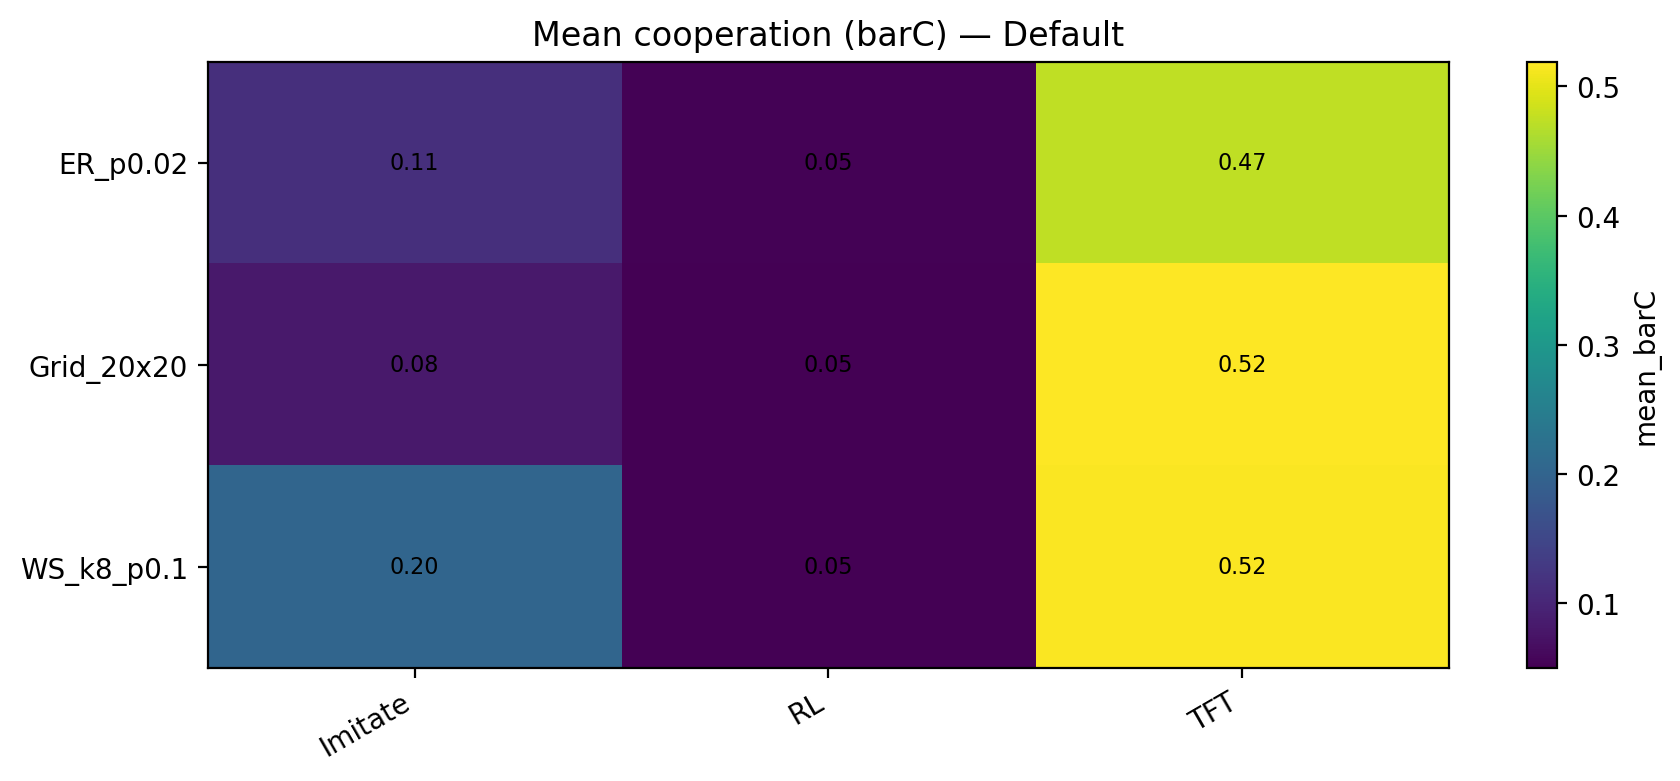

<IPython.core.display.Javascript object>

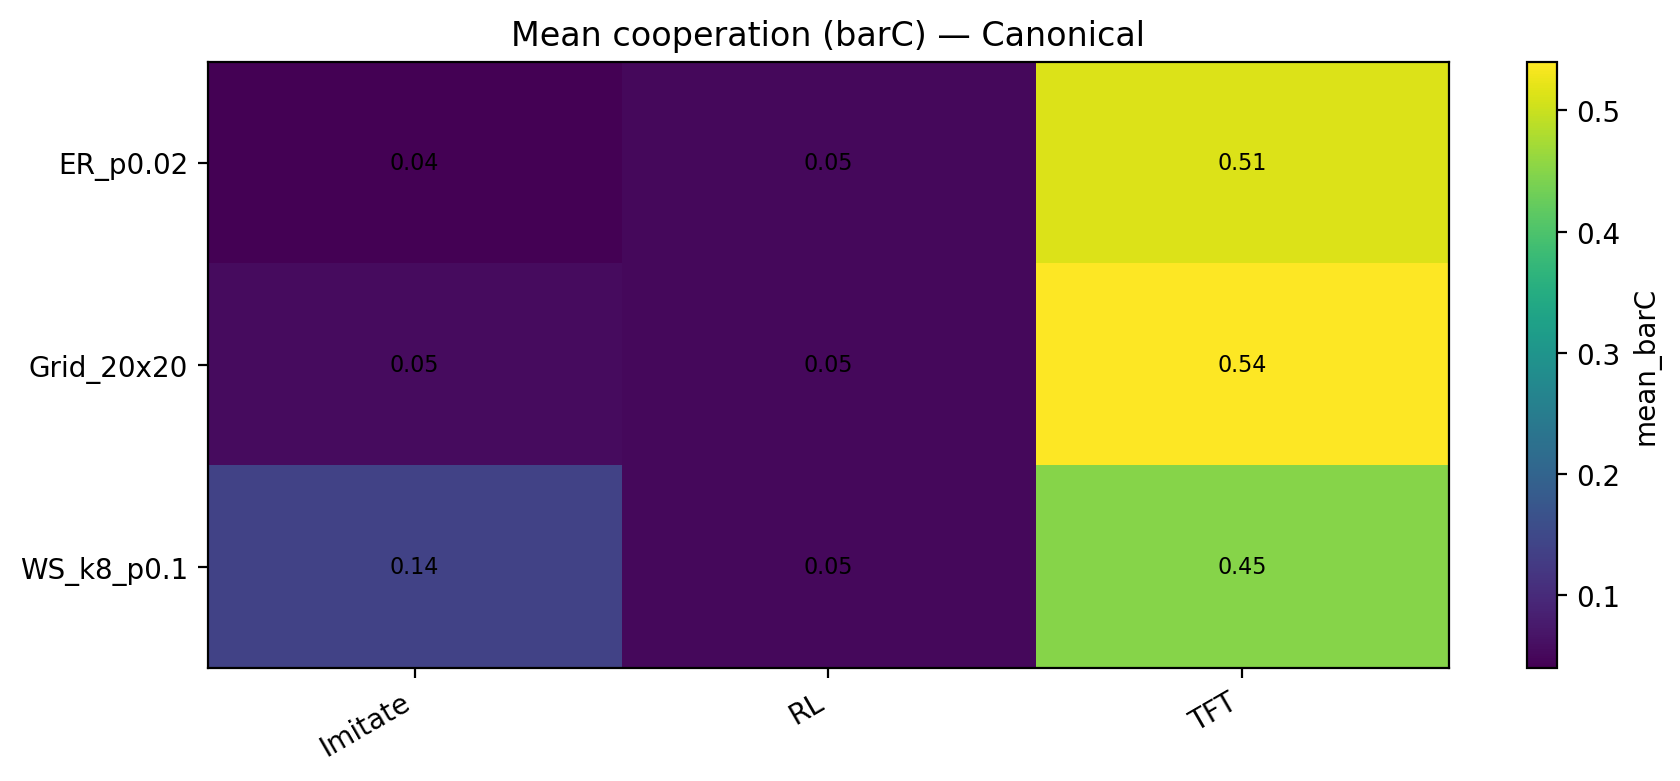

<IPython.core.display.Javascript object>

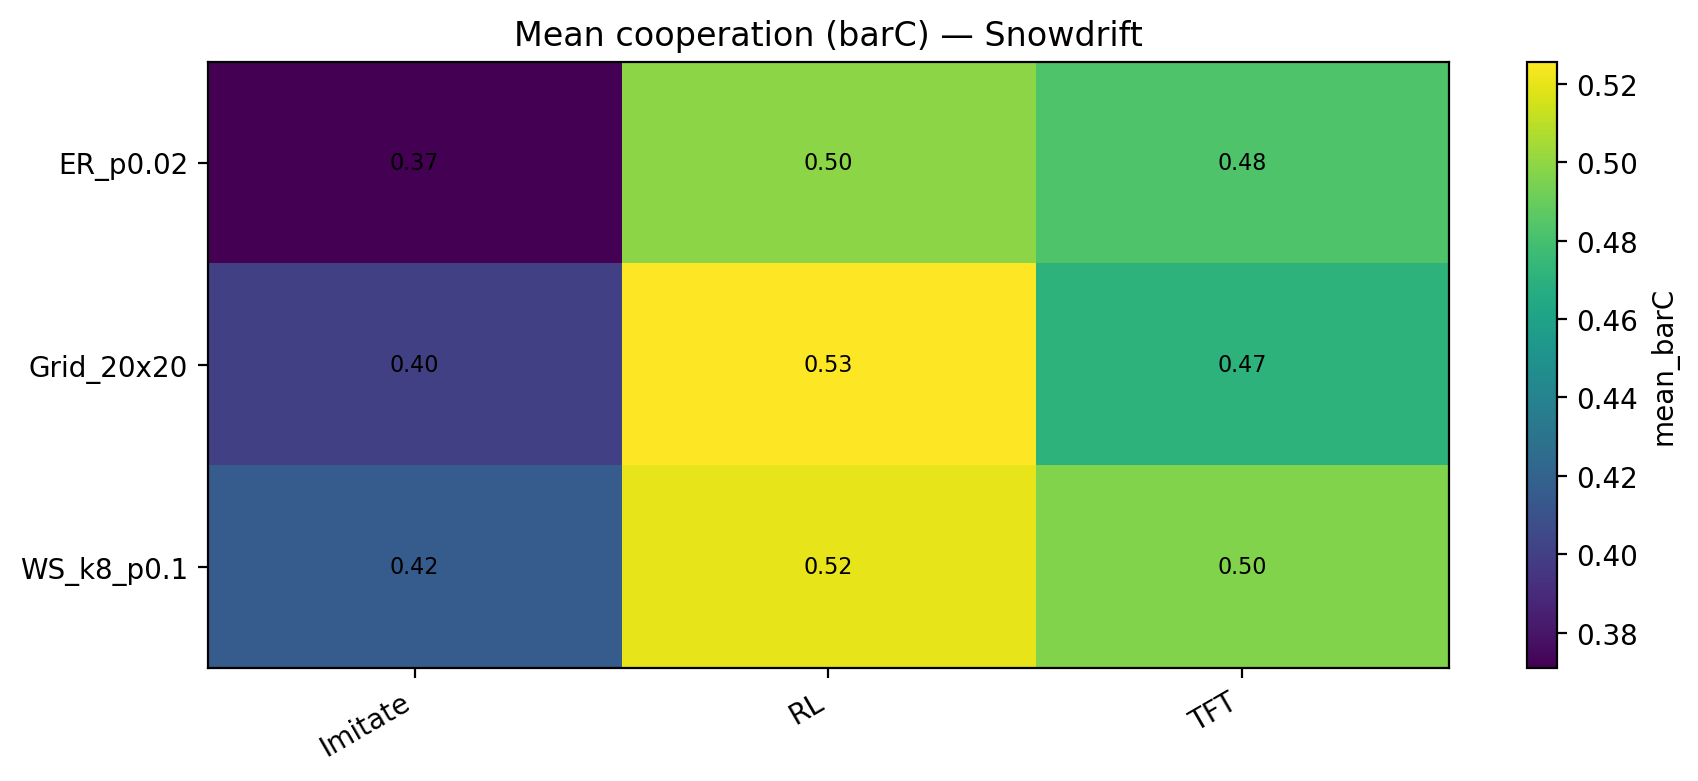

'figures/heatmap_Snowdrift.png'

In [30]:
def heatmap_mean_barC_save(df, payoff_name, col="strategy"):
    sub = df[df["payoff"] == payoff_name].copy()
    if "strategy_short" in sub.columns:
        col = "strategy_short"
    mat = sub.pivot_table(index="network", columns=col, values="mean_barC", aggfunc="mean")

    fig, ax = plt.subplots(figsize=(9, 4))
    im = ax.imshow(mat.to_numpy(dtype=float), aspect="auto")
    fig.colorbar(im, ax=ax, label="mean_barC")

    ax.set_xticks(range(mat.shape[1]))
    ax.set_xticklabels(mat.columns, rotation=30, ha="right")
    ax.set_yticks(range(mat.shape[0]))
    ax.set_yticklabels(mat.index)
    ax.set_title(f"Mean cooperation (barC) — {payoff_name}")

    # annotate numbers
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            v = mat.iat[i, j]
            if np.isfinite(v):
                ax.text(j, i, f"{v:.2f}", ha="center", va="center", fontsize=8)

    fig.tight_layout()
    return show_saved(fig, f"heatmap_{payoff_name}.png")

heatmap_mean_barC_save(summary_revised, "Default")
heatmap_mean_barC_save(summary_revised, "Canonical")
heatmap_mean_barC_save(summary_revised, "Snowdrift")


<IPython.core.display.Javascript object>

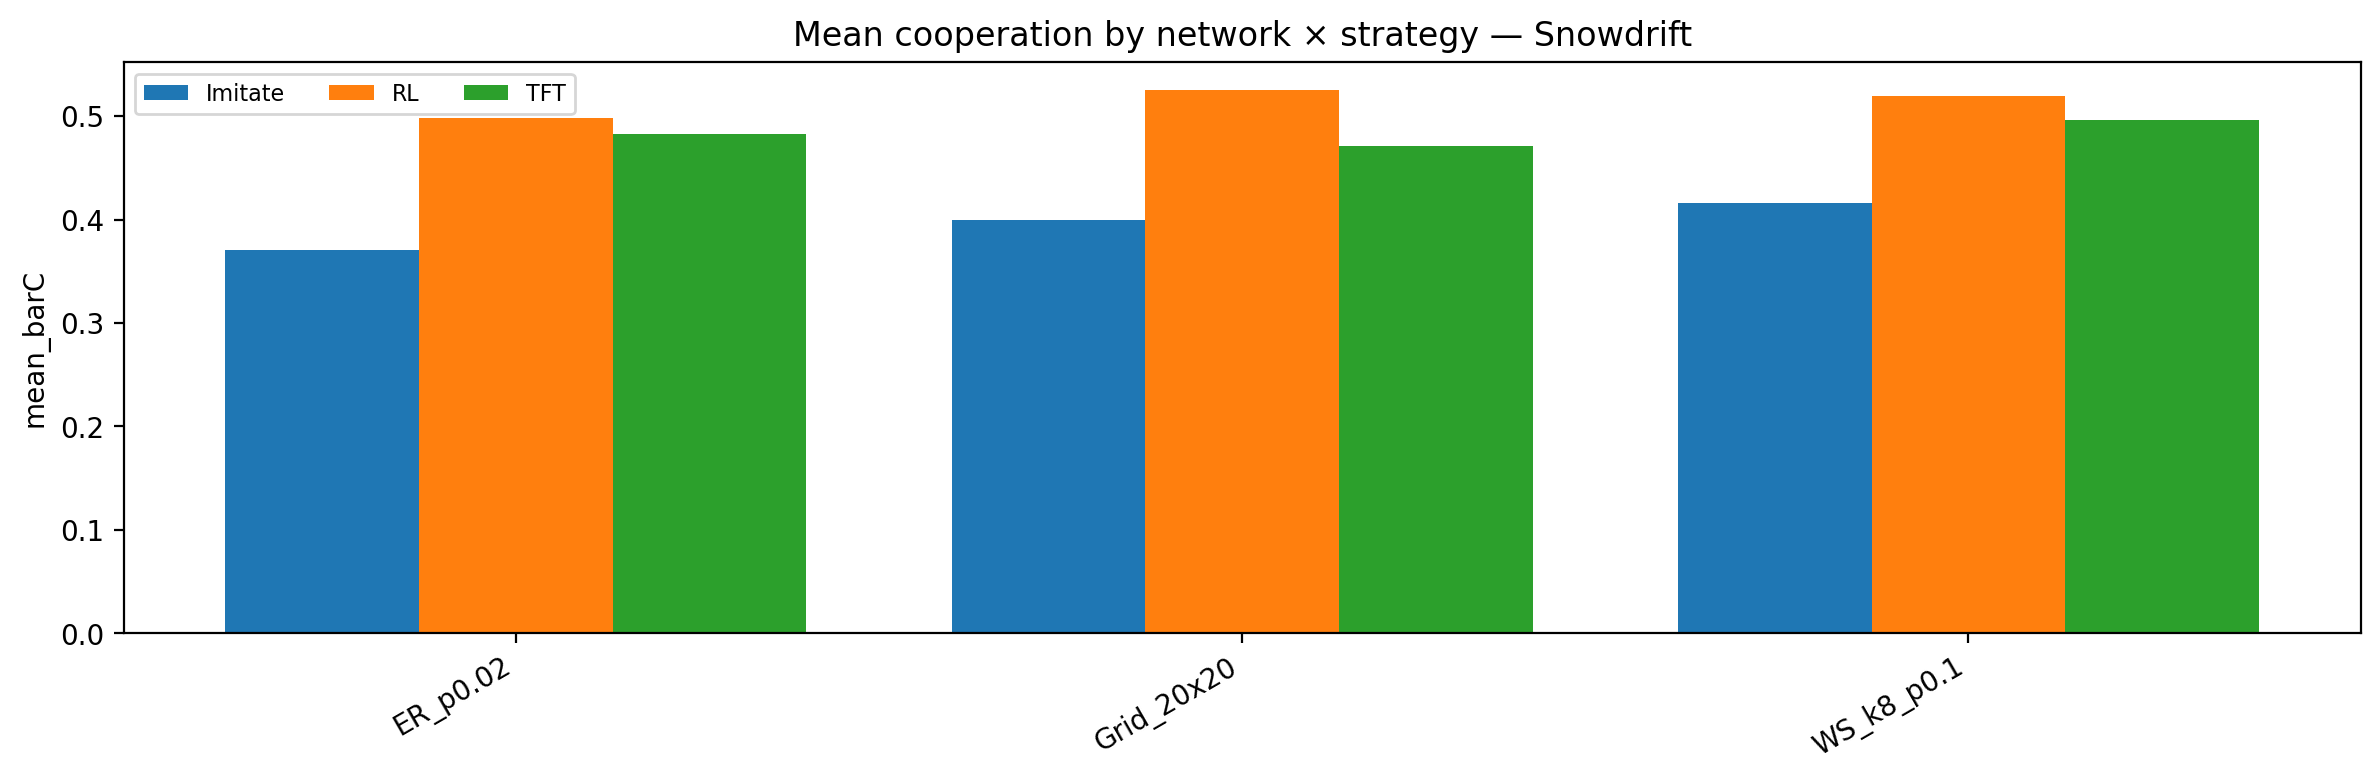

<IPython.core.display.Javascript object>

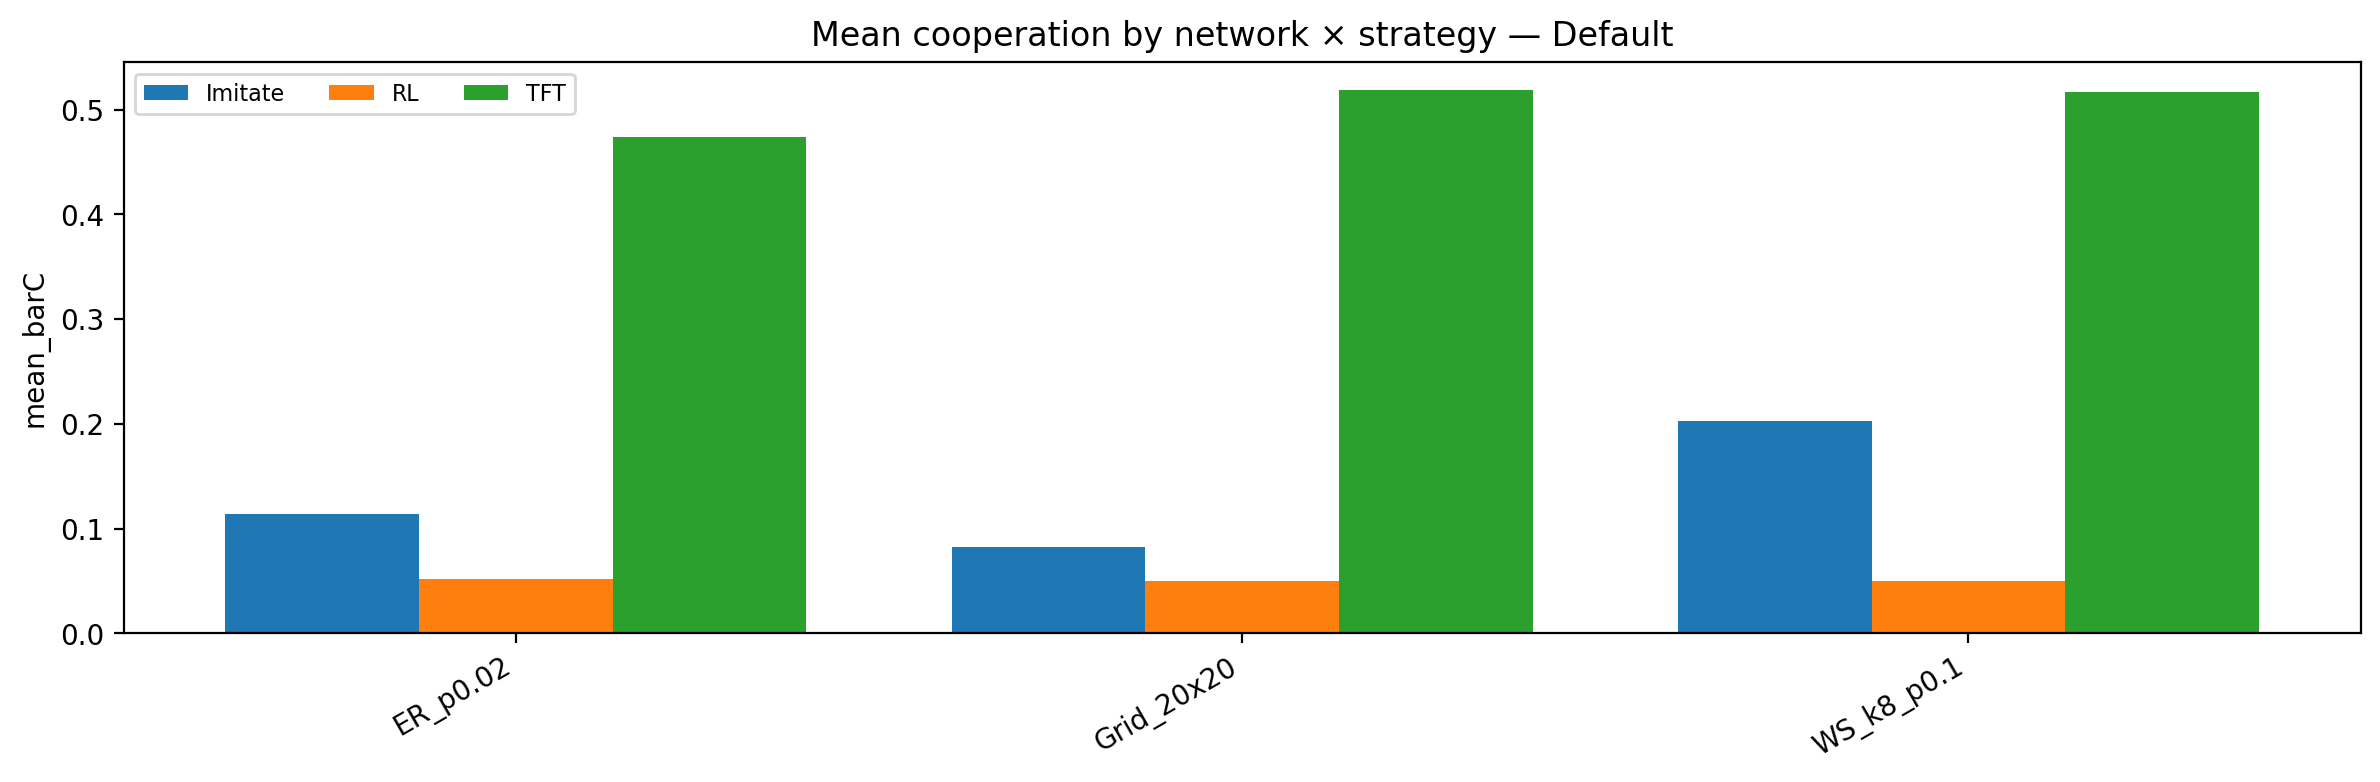

<IPython.core.display.Javascript object>

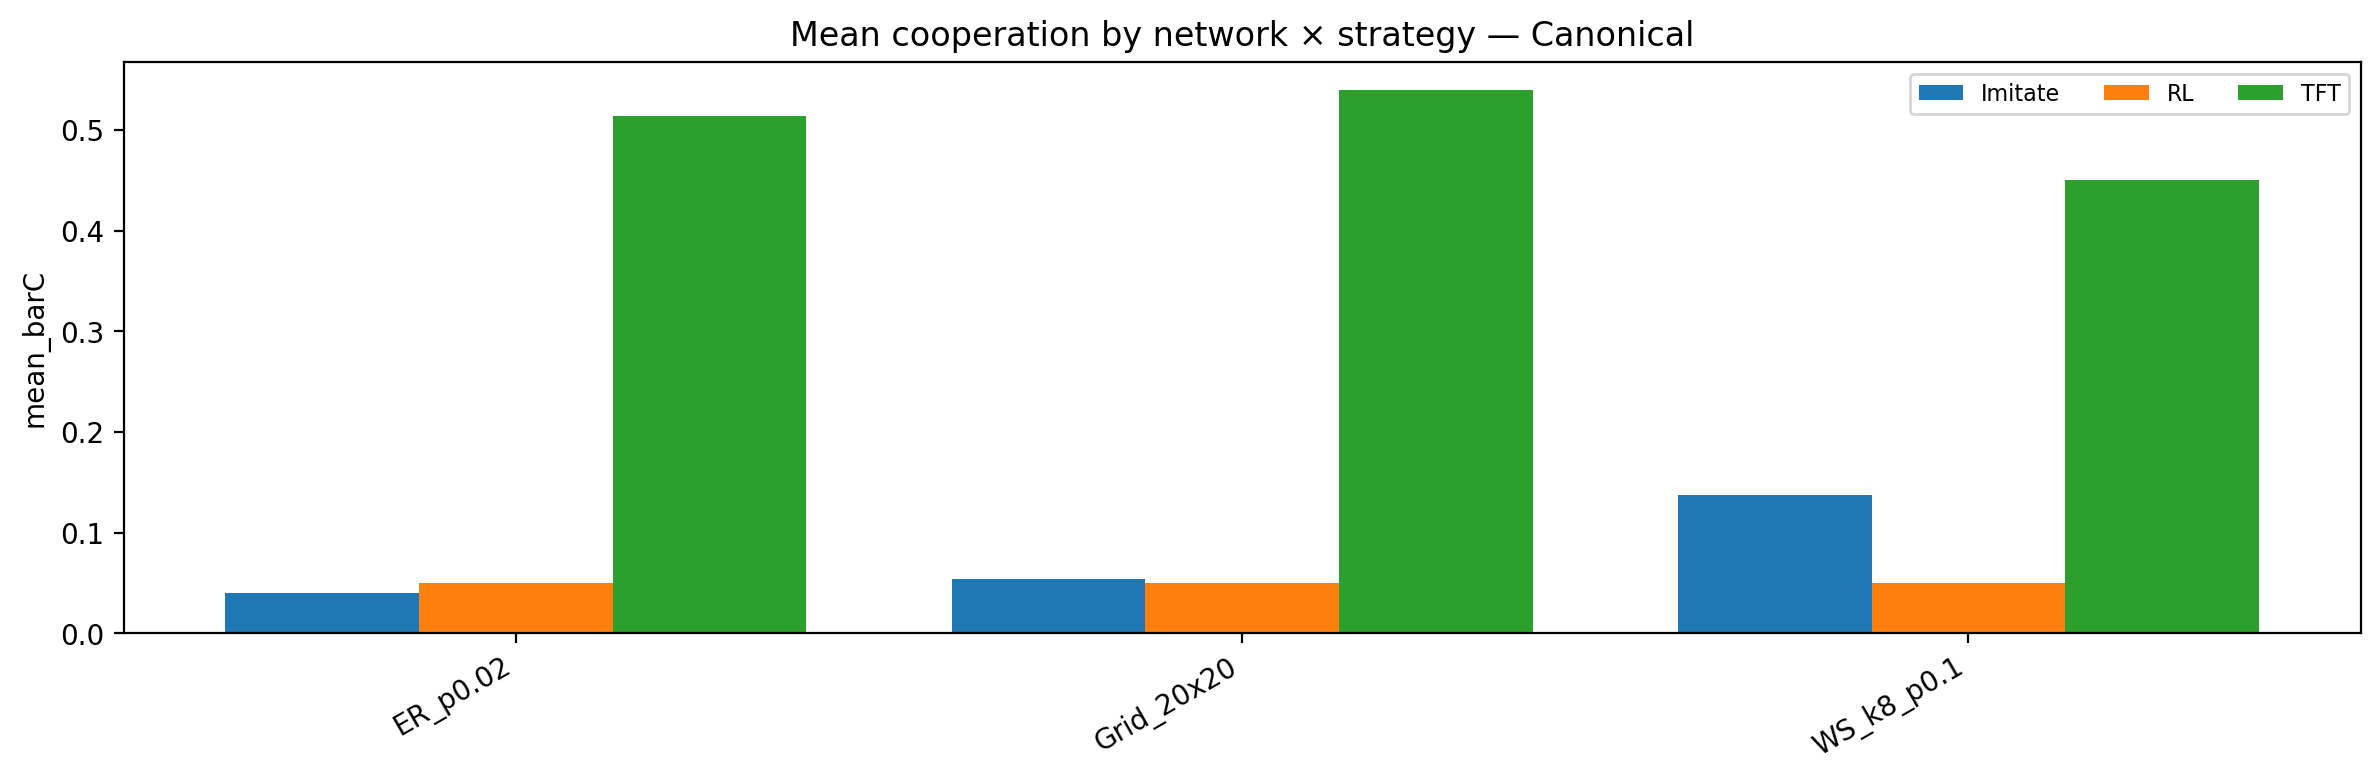

'figures/groupedbars_mean_barC_Canonical.png'

In [31]:
def plot_groupedbars_mean_barC(summary_df, payoff_name, use_short=True):
    sub = summary_df[summary_df["payoff"] == payoff_name].copy()
    strat_col = "strategy_short" if (use_short and "strategy_short" in sub.columns) else "strategy"

    pivot = sub.pivot_table(index="network", columns=strat_col, values="mean_barC", aggfunc="mean")
    networks = list(pivot.index)
    strategies = list(pivot.columns)

    x = np.arange(len(networks))
    width = 0.8 / max(len(strategies), 1)

    fig, ax = plt.subplots(figsize=(12, 4))
    for k, s in enumerate(strategies):
        ax.bar(x + (k - (len(strategies)-1)/2)*width, pivot[s].values, width, label=str(s))

    ax.set_xticks(x)
    ax.set_xticklabels(networks, rotation=30, ha="right")
    ax.set_ylabel("mean_barC")
    ax.set_title(f"Mean cooperation by network × strategy — {payoff_name}")
    ax.legend(ncols=min(4, len(strategies)), fontsize=8)
    fig.tight_layout()

    return show_saved(fig, f"groupedbars_mean_barC_{payoff_name}.png")

plot_groupedbars_mean_barC(summary_revised, "Snowdrift")
plot_groupedbars_mean_barC(summary_revised, "Default")
plot_groupedbars_mean_barC(summary_revised, "Canonical")

<IPython.core.display.Javascript object>

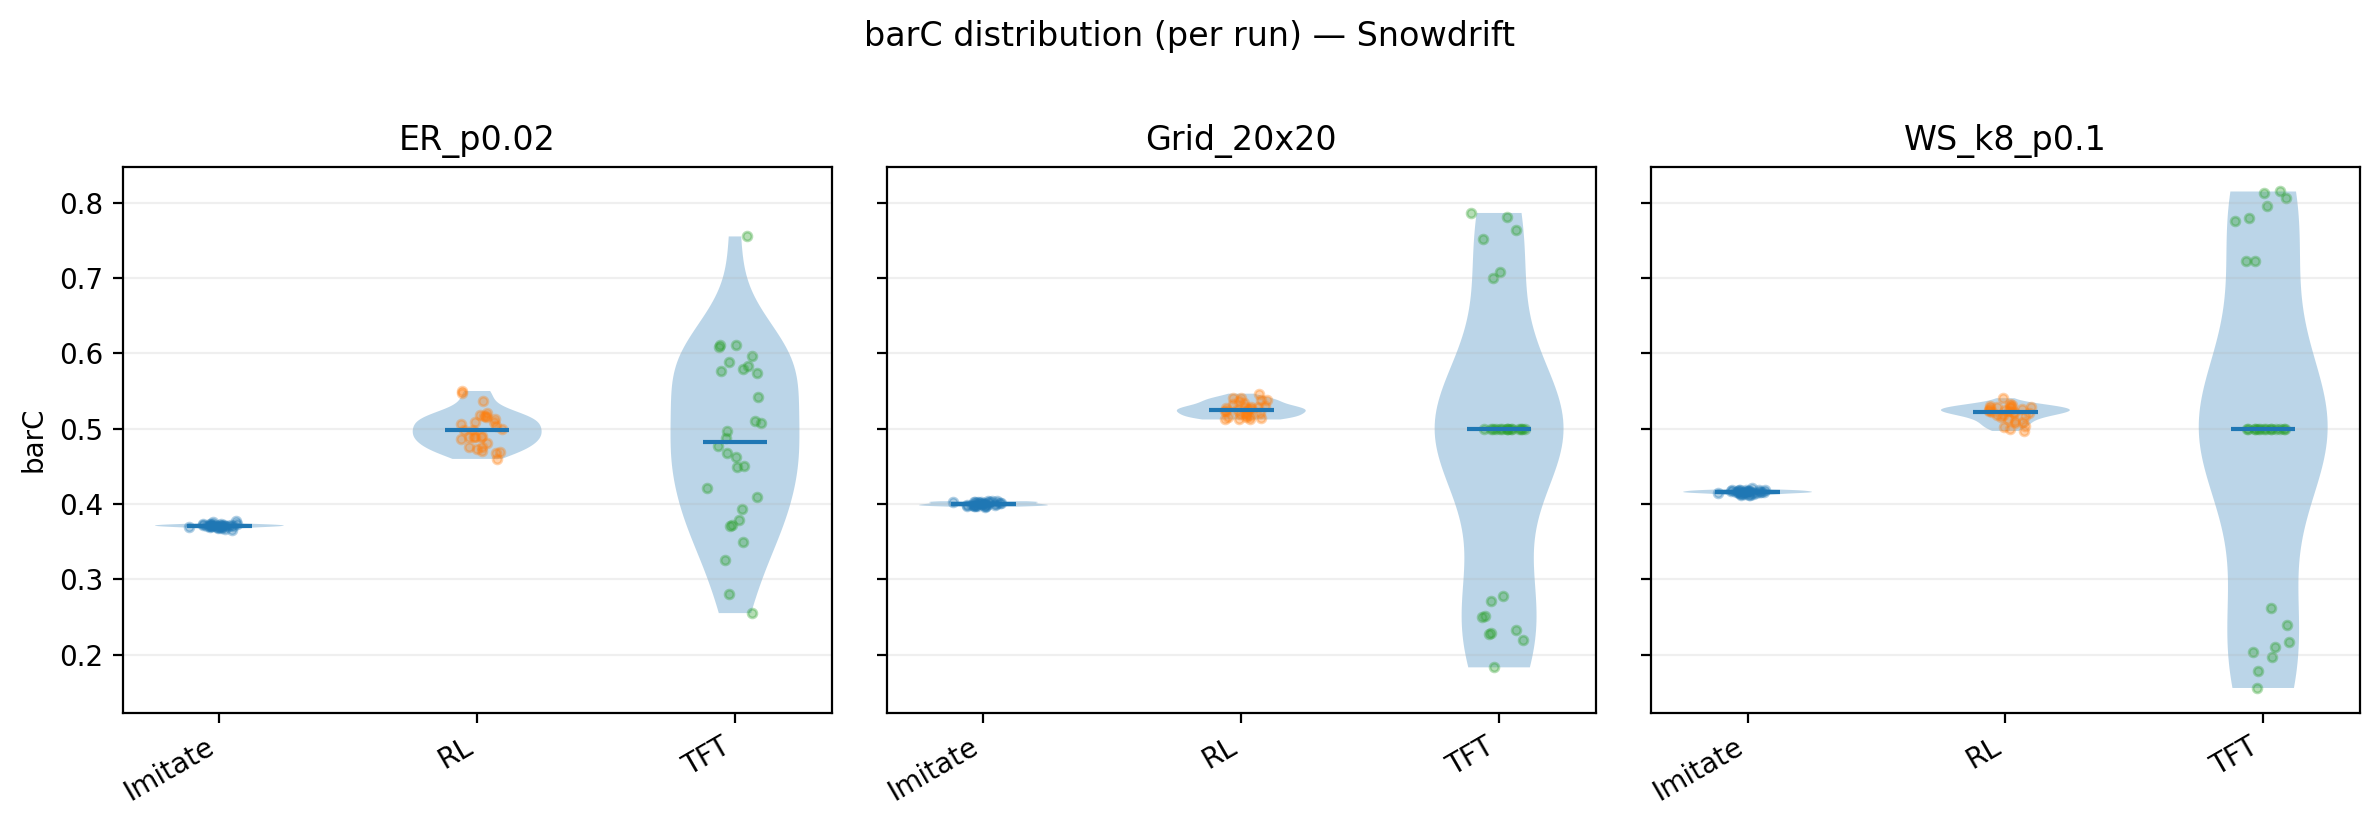

<IPython.core.display.Javascript object>

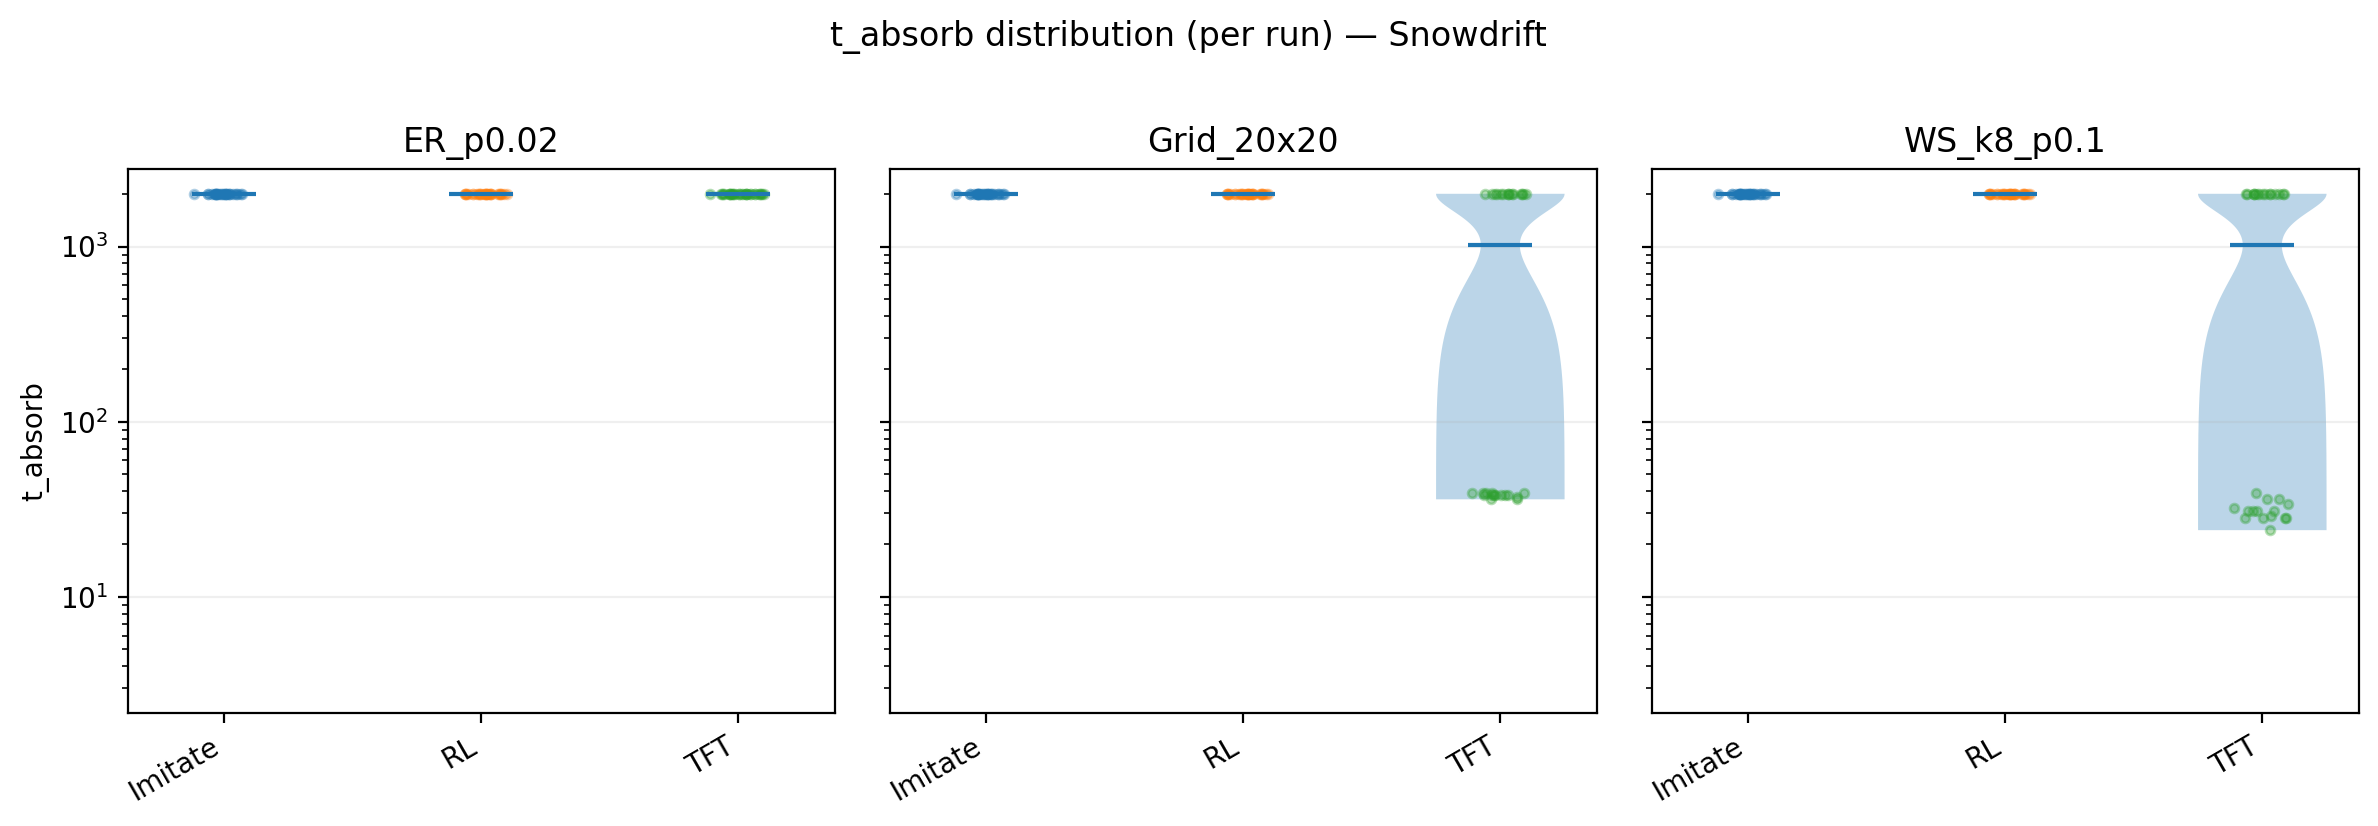

<IPython.core.display.Javascript object>

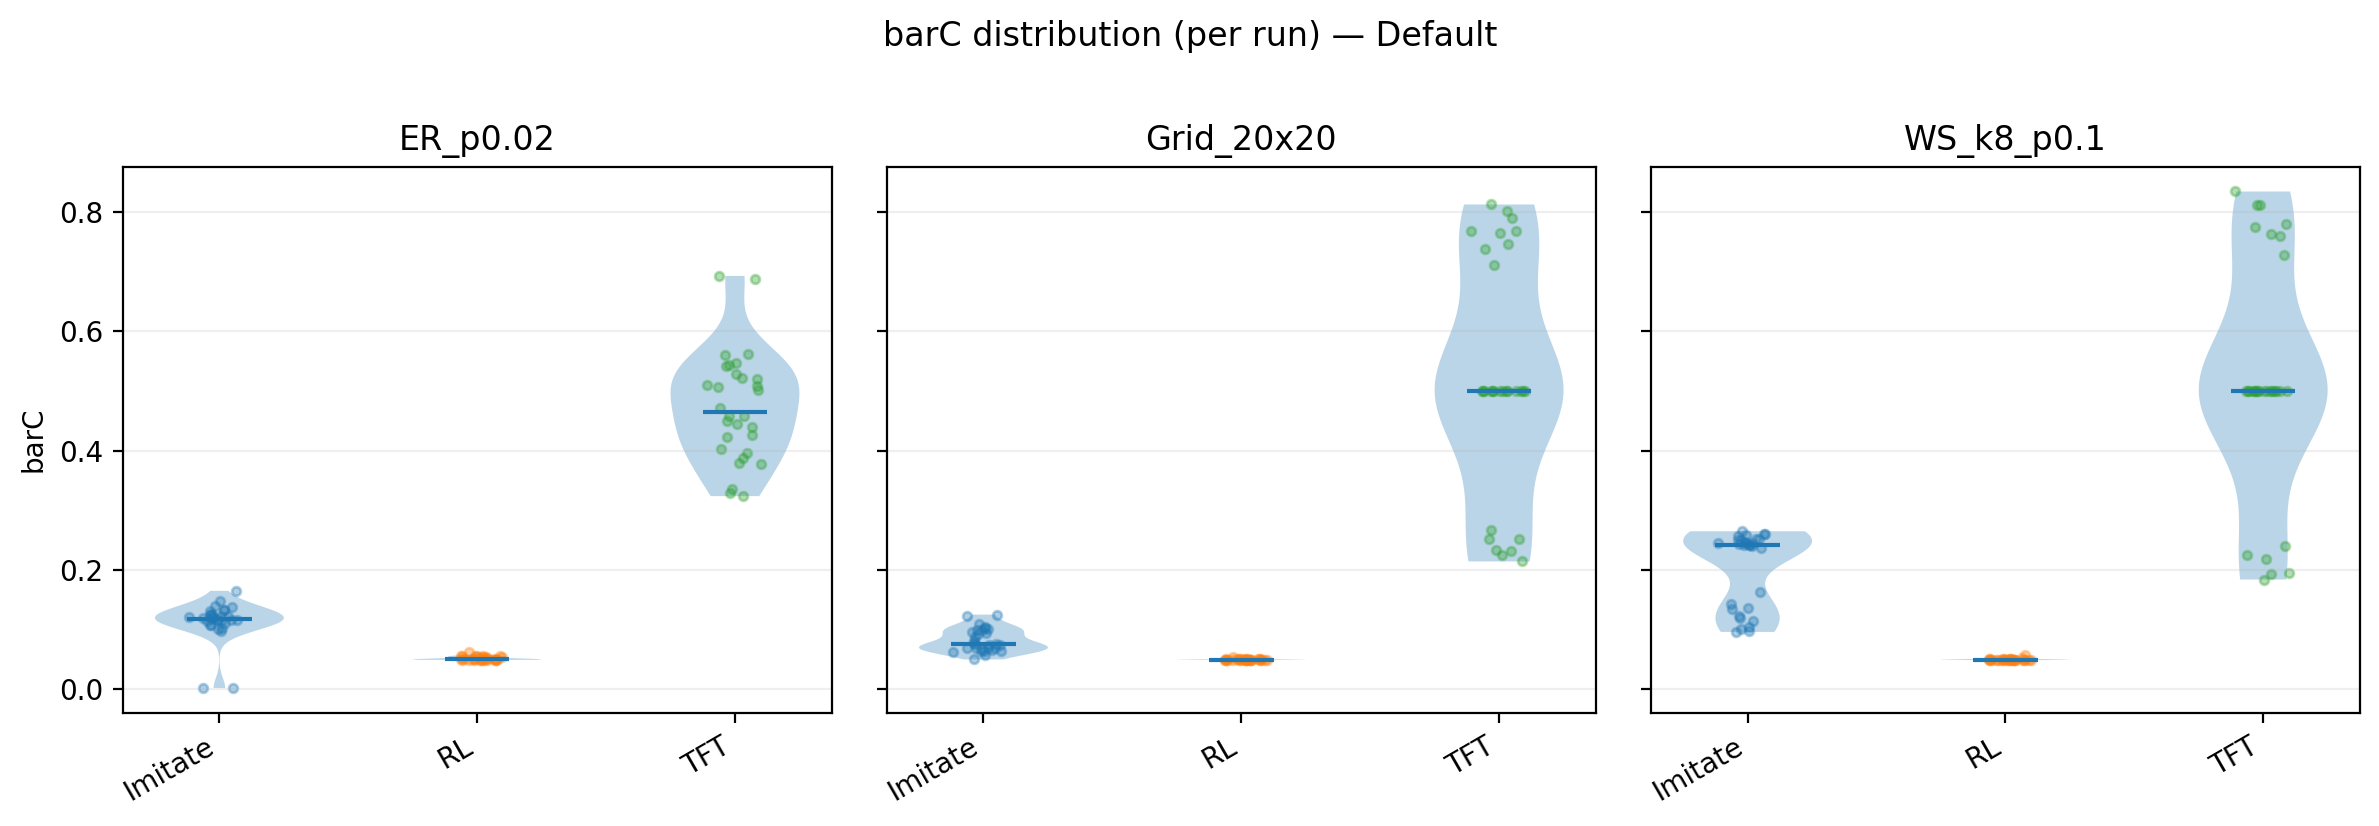

<IPython.core.display.Javascript object>

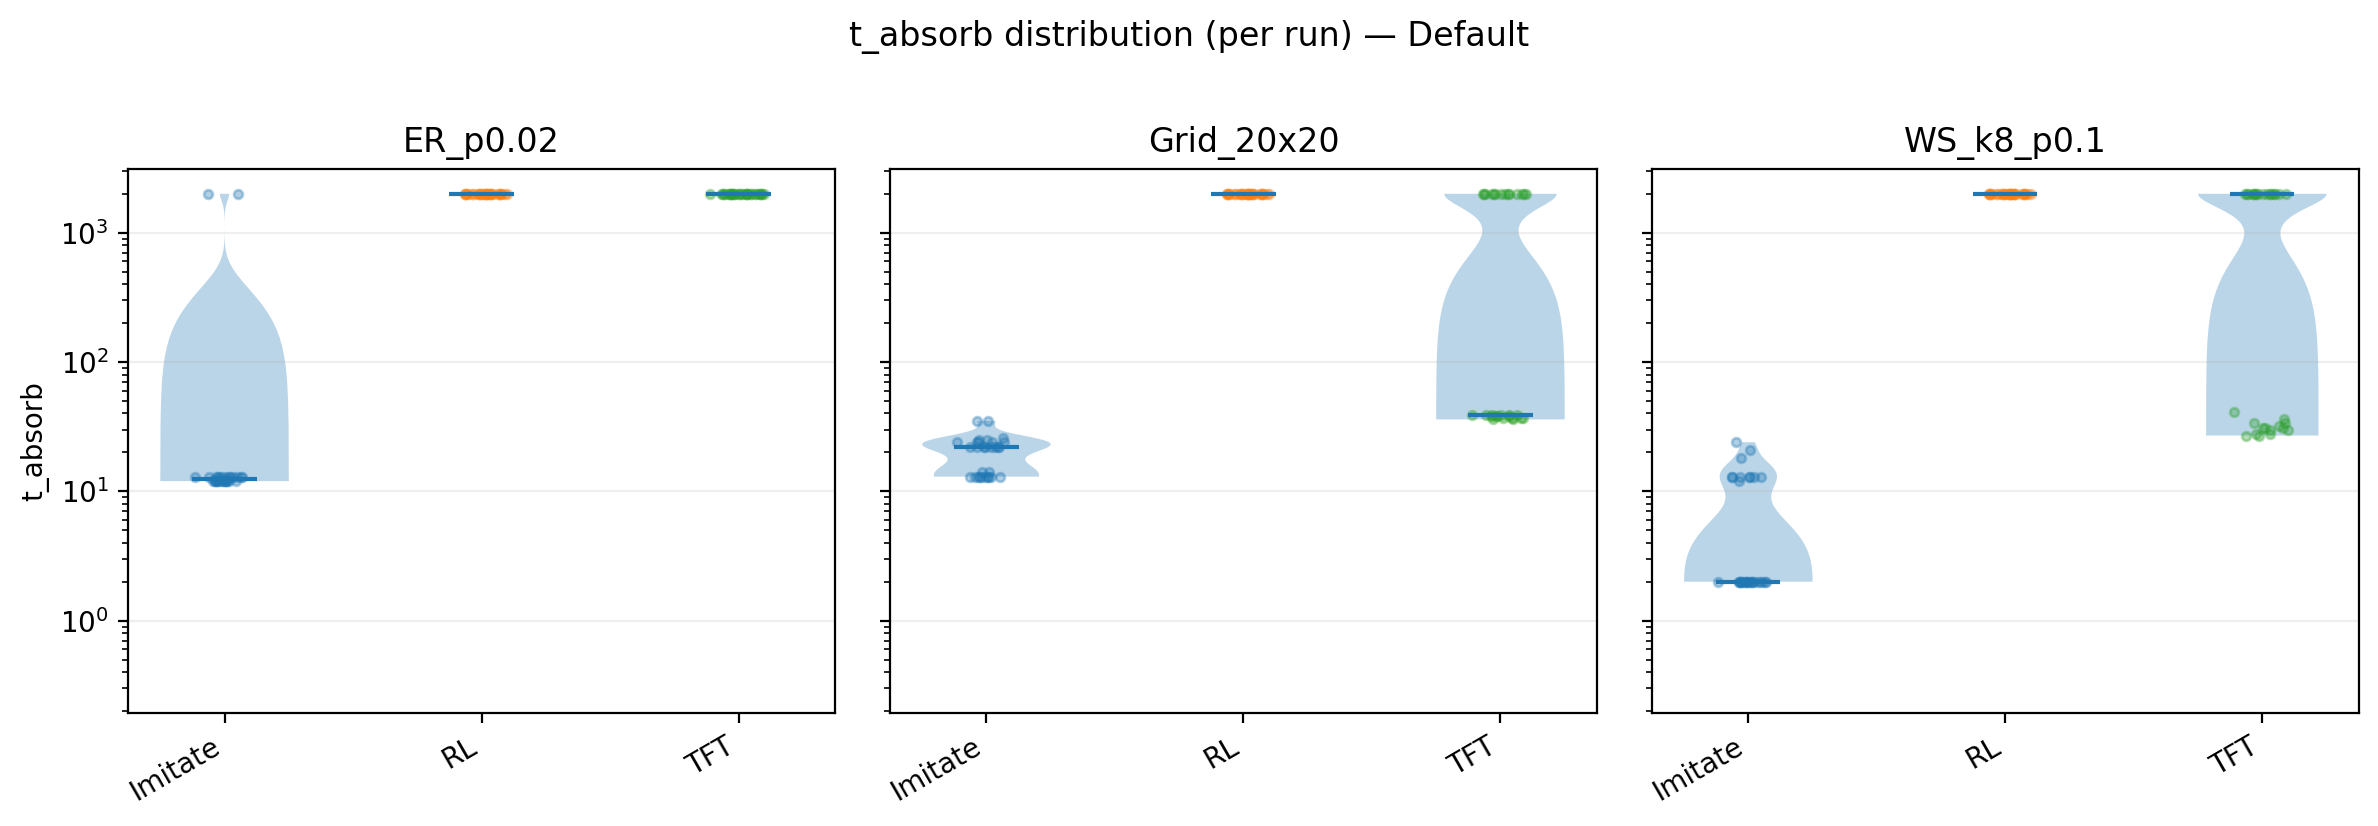

<IPython.core.display.Javascript object>

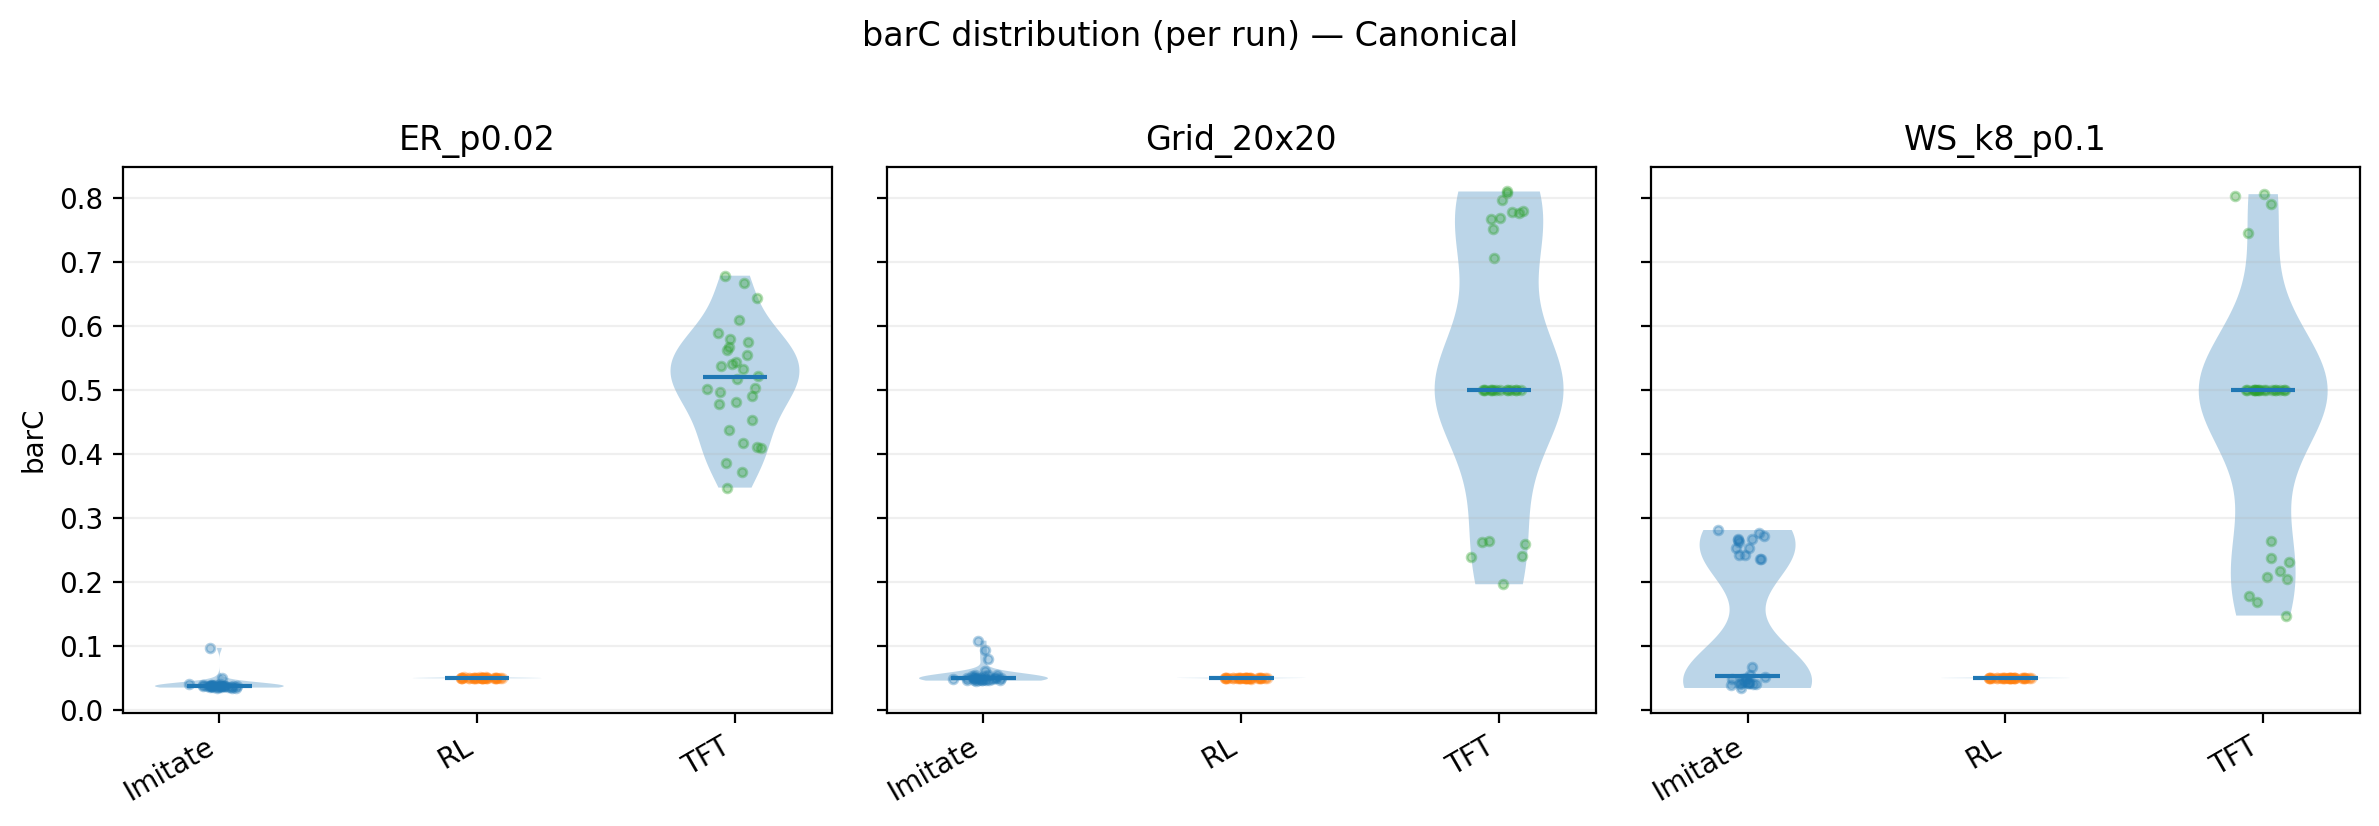

<IPython.core.display.Javascript object>

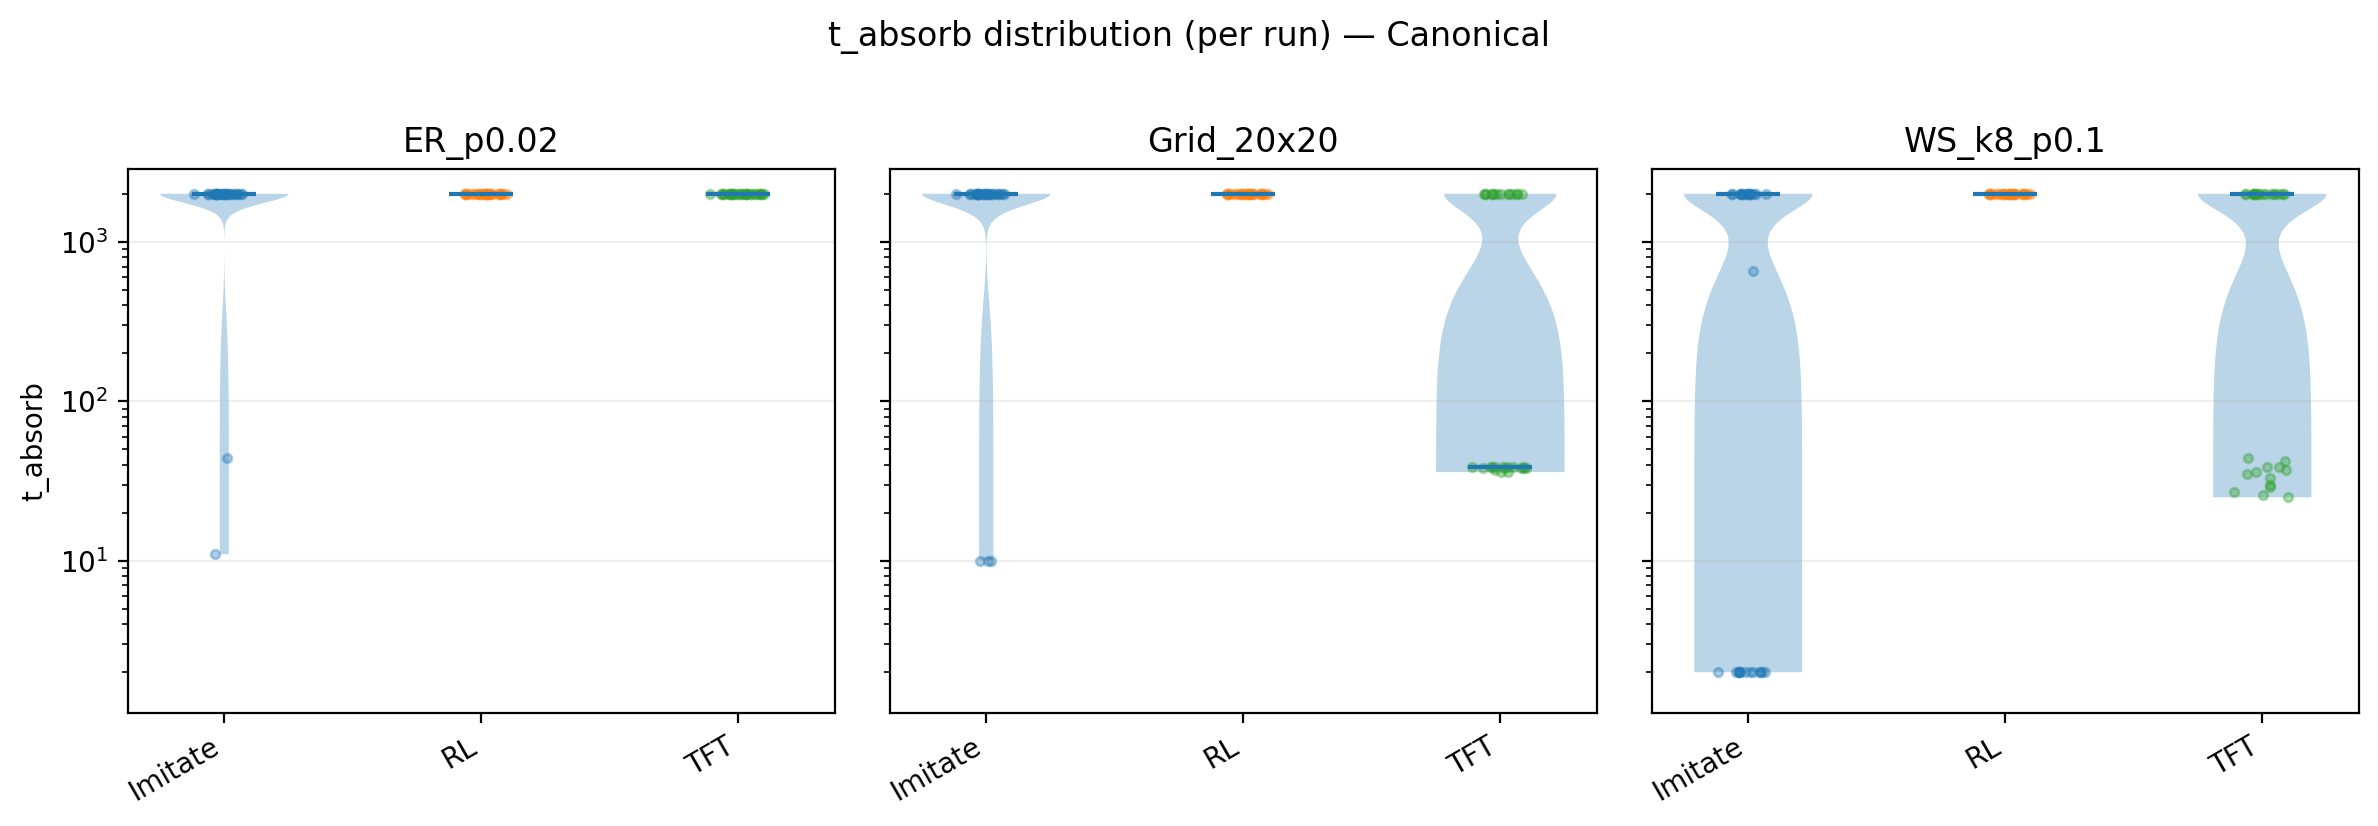

'figures/violin_t_absorb_Canonical.png'

In [37]:
def violin_by_network_strategy(per_run_df, payoff_name, metric,
                               use_short=True, logy=False, ylim=None):
    sub = per_run_df[per_run_df["payoff"] == payoff_name].copy()
    strat_col = "strategy_short" if (use_short and "strategy_short" in sub.columns) else "strategy"

    need = ["network", strat_col, metric]
    for c in need:
        if c not in sub.columns:
            raise ValueError(f"Missing column: {c}")

    networks = sorted(sub["network"].unique())
    strategies = sorted(sub[strat_col].unique())

    fig, axes = plt.subplots(1, len(networks), figsize=(4*len(networks), 4), sharey=True)
    if len(networks) == 1:
        axes = [axes]

    for ax, net in zip(axes, networks):
        g = sub[sub["network"] == net]

        data = []
        for s in strategies:
            vals = g.loc[g[strat_col] == s, metric].dropna().to_numpy()
            data.append(vals)

        # violin
        parts = ax.violinplot(data, showmeans=False, showmedians=True, showextrema=False)

        # jittered points (helps see sample size / discreteness)
        rng = np.random.default_rng(0)
        for i, vals in enumerate(data, start=1):
            if len(vals) == 0:
                continue
            x = i + rng.normal(0, 0.05, size=len(vals))
            ax.scatter(x, vals, s=10, alpha=0.35)

        ax.set_title(str(net))
        ax.set_xticks(range(1, len(strategies)+1))
        ax.set_xticklabels(strategies, rotation=30, ha="right")

        if logy:
            ax.set_yscale("log")

        if ylim is not None:
            ax.set_ylim(*ylim)

        ax.grid(True, axis="y", alpha=0.2)

    fig.suptitle(f"{metric} distribution (per run) — {payoff_name}", y=1.02)
    axes[0].set_ylabel(metric)
    fig.tight_layout()
    return show_saved(fig, f"violin_{metric}_{payoff_name}.png")

# Examples:
violin_by_network_strategy(per_run_revised, "Snowdrift", metric="barC", logy=False)
violin_by_network_strategy(per_run_revised, "Snowdrift", metric="t_absorb", logy=True)
violin_by_network_strategy(per_run_revised, "Default", metric="barC")
violin_by_network_strategy(per_run_revised, "Default", metric="t_absorb", logy=True)
violin_by_network_strategy(per_run_revised, "Canonical", metric="barC")
violin_by_network_strategy(per_run_revised, "Canonical", metric="t_absorb", logy=True)


<IPython.core.display.Javascript object>

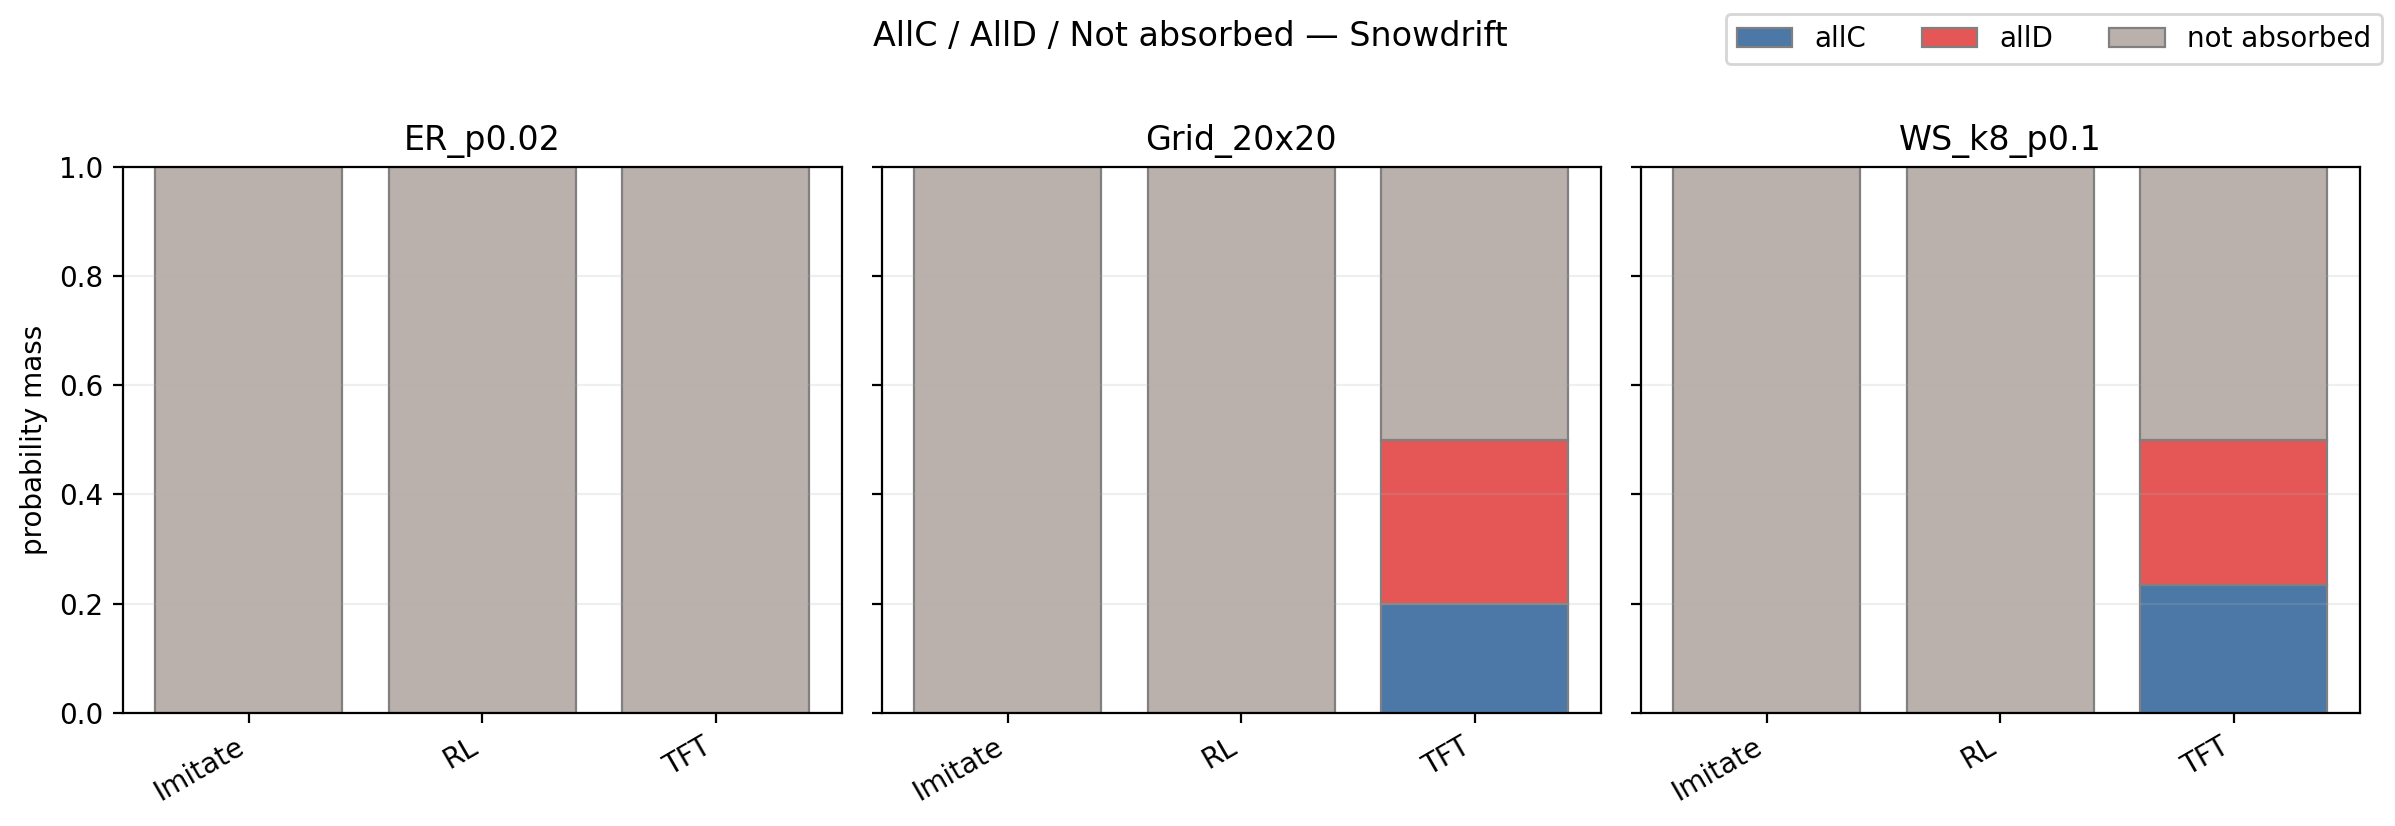

<IPython.core.display.Javascript object>

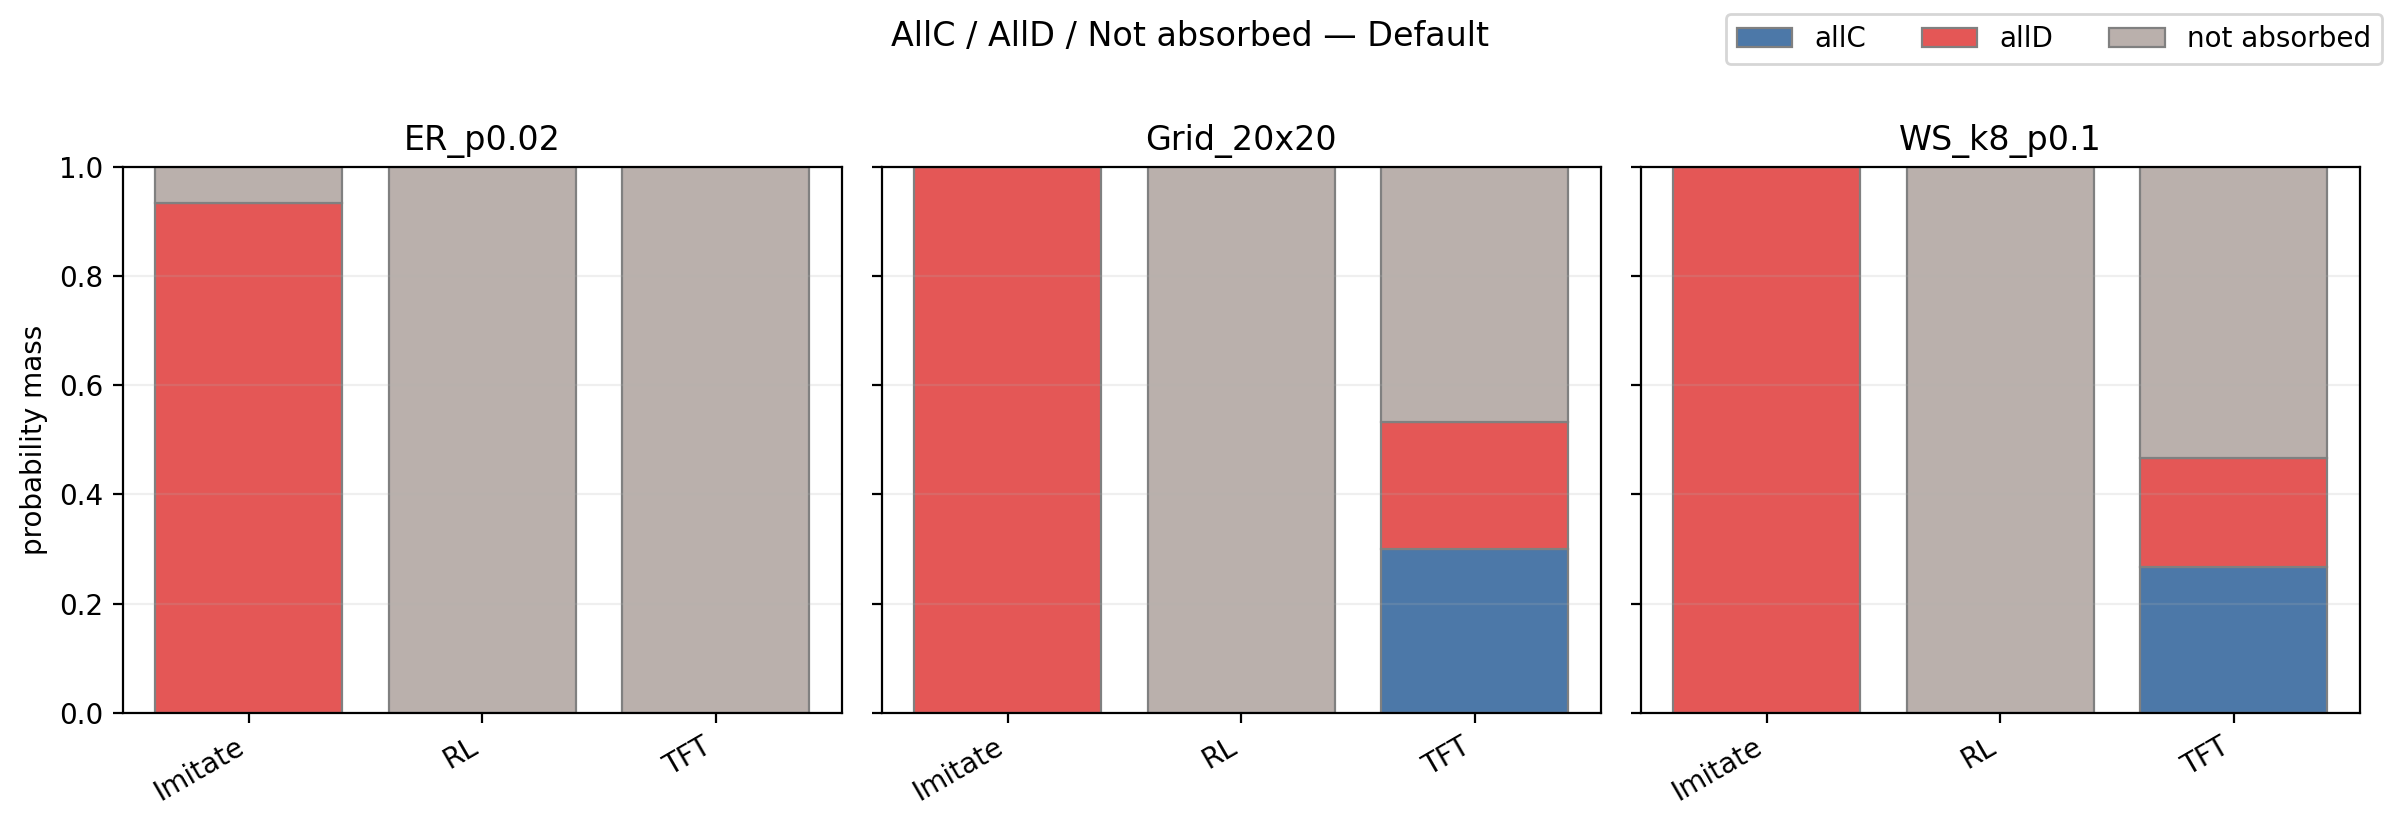

<IPython.core.display.Javascript object>

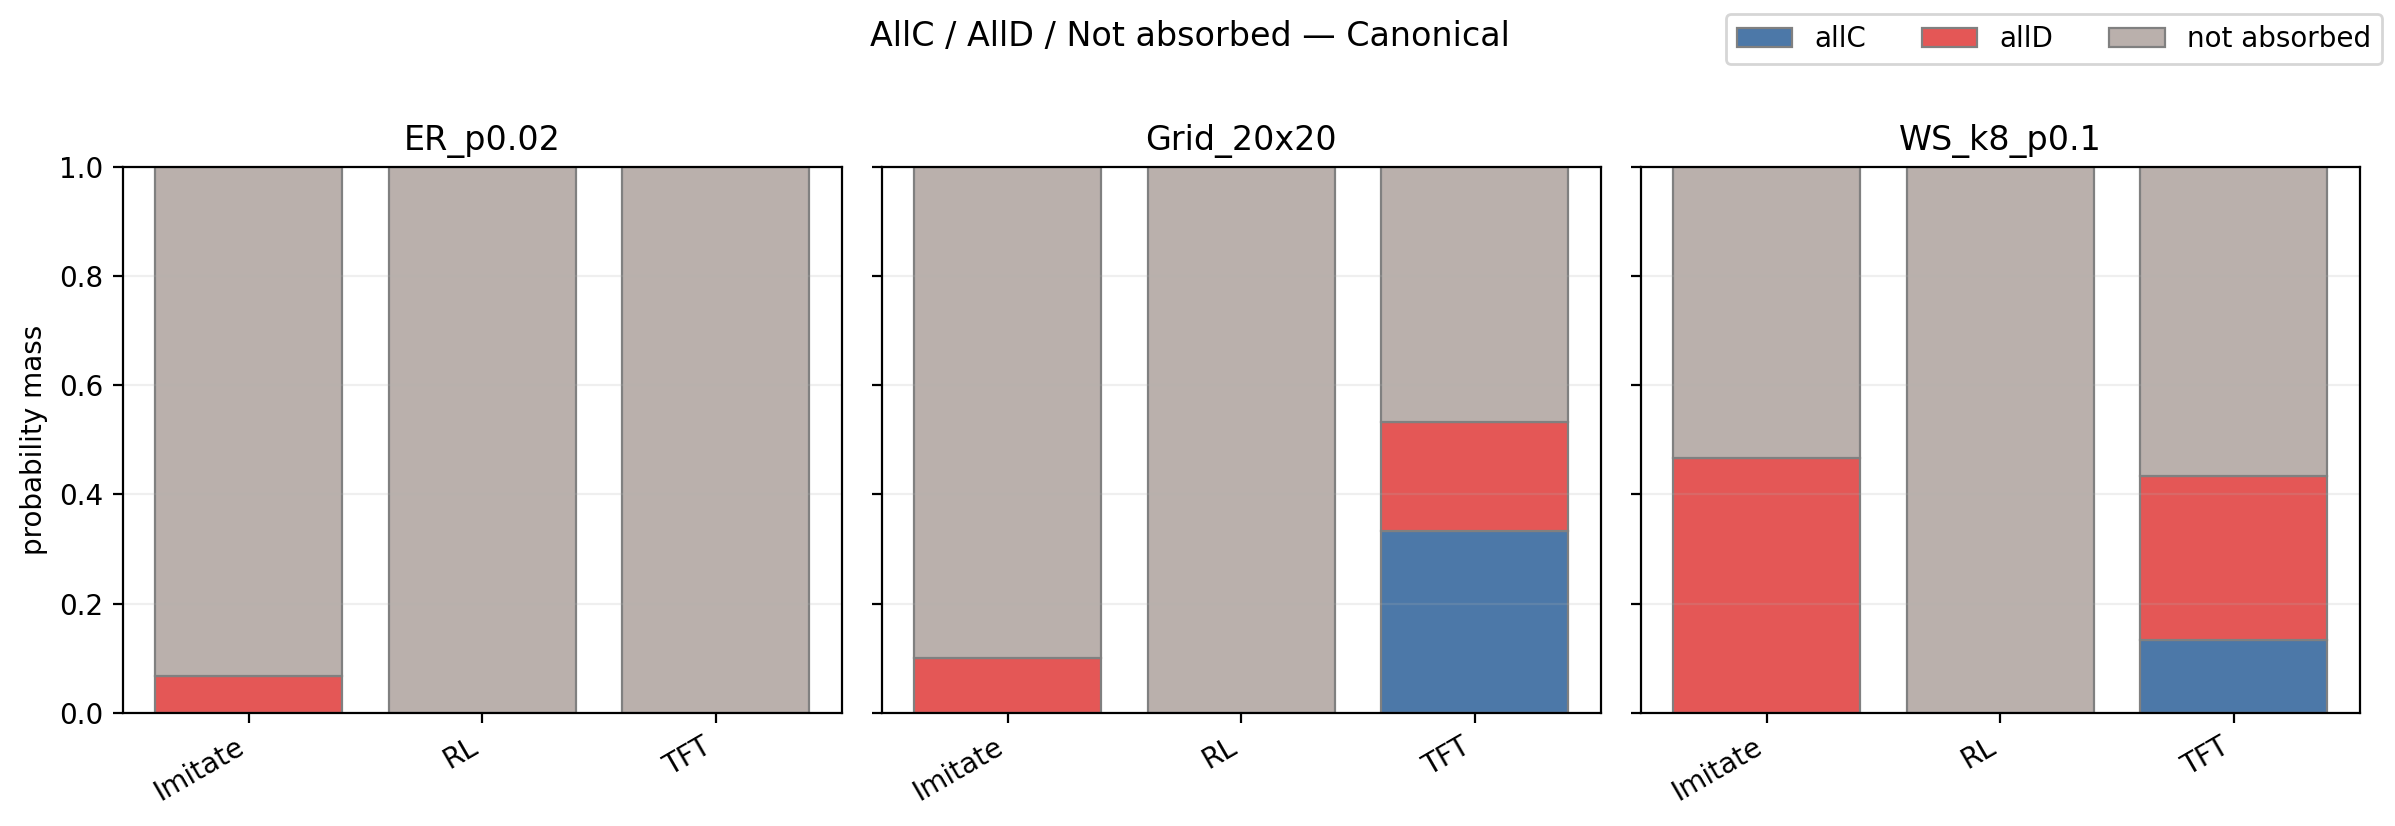

'figures/stacked_Pr_allC_allD_active_Canonical.png'

In [55]:
def plot_probs_stacked(per_run_df, payoff_name, use_short=True, colors=None):
    sub = per_run_df[per_run_df["payoff"] == payoff_name].copy()
    strat_col = "strategy_short" if (use_short and "strategy_short" in sub.columns) else "strategy"

    for c in ["network", strat_col, "absorbed", "absorb_state"]:
        if c not in sub.columns:
            raise ValueError(f"Missing column: {c}")

    # default colors (edit as you like)
    if colors is None:
        colors = {
            "allC":   "#4C78A8",
            "allD":   "#E45756",
            "active": "#BAB0AC",
        }

    rows = []
    for (net, strat), g in sub.groupby(["network", strat_col]):
        n = len(g)
        kC = int((g["absorbed"].astype(int).eq(1) & g["absorb_state"].eq("allC")).sum())
        kD = int((g["absorbed"].astype(int).eq(1) & g["absorb_state"].eq("allD")).sum())
        pC = kC / n
        pD = kD / n
        pA = 1 - pC - pD
        rows.append([net, strat, pC, pD, pA])

    tab = pd.DataFrame(rows, columns=["network", "strategy", "p_allC", "p_allD", "p_active"])

    networks = sorted(tab["network"].unique())
    strategies = sorted(tab["strategy"].unique())

    fig, axes = plt.subplots(1, len(networks), figsize=(4*len(networks), 4), sharey=True)
    if len(networks) == 1:
        axes = [axes]

    for ax, net in zip(axes, networks):
        g = tab[tab["network"] == net].set_index("strategy").reindex(strategies)

        x = np.arange(len(strategies))
        ax.bar(x, g["p_allC"], color=colors["allC"], label="allC", edgecolor="gray", linewidth=0.8)
        ax.bar(x, g["p_allD"], bottom=g["p_allC"], color=colors["allD"], label="allD", edgecolor="gray", linewidth=0.8)
        ax.bar(x, g["p_active"],
               bottom=g["p_allC"] + g["p_allD"],
               color=colors["active"], label="not absorbed",
               edgecolor="gray", linewidth=0.8
               )

        ax.set_xticks(x)
        ax.set_xticklabels(strategies, rotation=30, ha="right")
        ax.set_ylim(0, 1)
        ax.set_title(str(net))
        ax.grid(True, axis="y", alpha=0.2)

    axes[0].set_ylabel("probability mass")
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper right", ncols=3, frameon=True)
    fig.suptitle(f"AllC / AllD / Not absorbed — {payoff_name}", y=1.02)
    fig.tight_layout()

    return show_saved(fig, f"stacked_Pr_allC_allD_active_{payoff_name}.png")



plot_probs_stacked(per_run_revised, "Snowdrift")
plot_probs_stacked(per_run_revised, "Default")
plot_probs_stacked(per_run_revised, "Canonical")